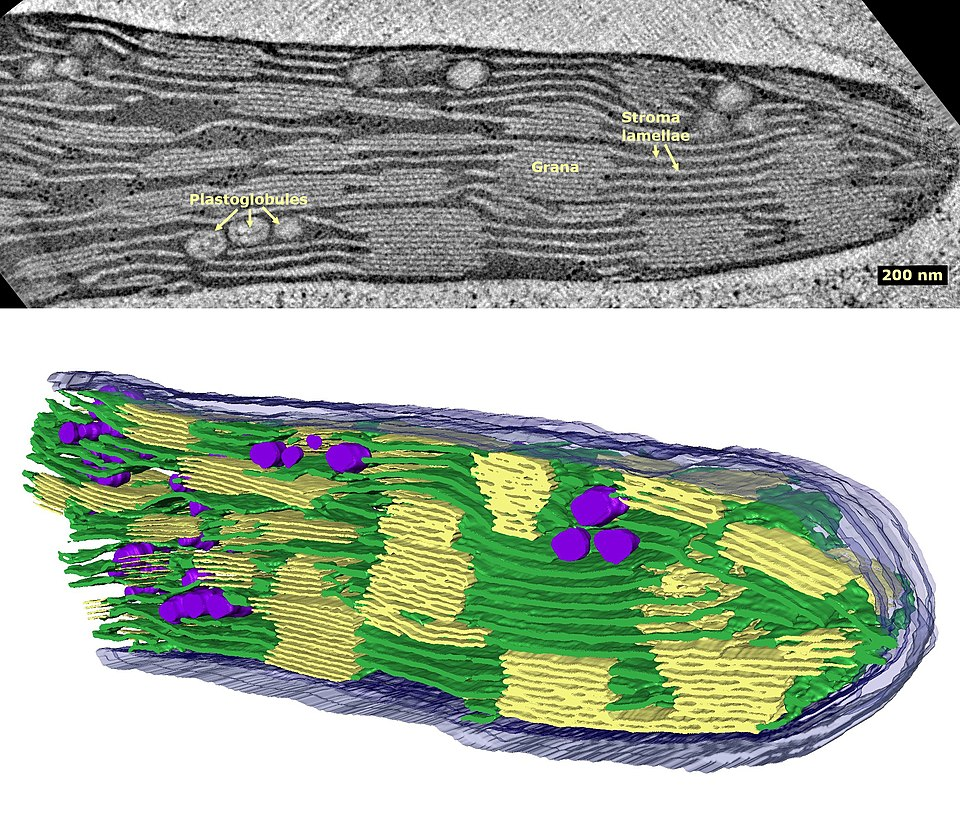

# In this Notebook, a model of the ***thylakoid system*** of chloroplasts is built using ***PyVista*** using as reference a cryo-EM structure.

## This work is part of the PhD thesis by Rubi Zarmiento Garcia

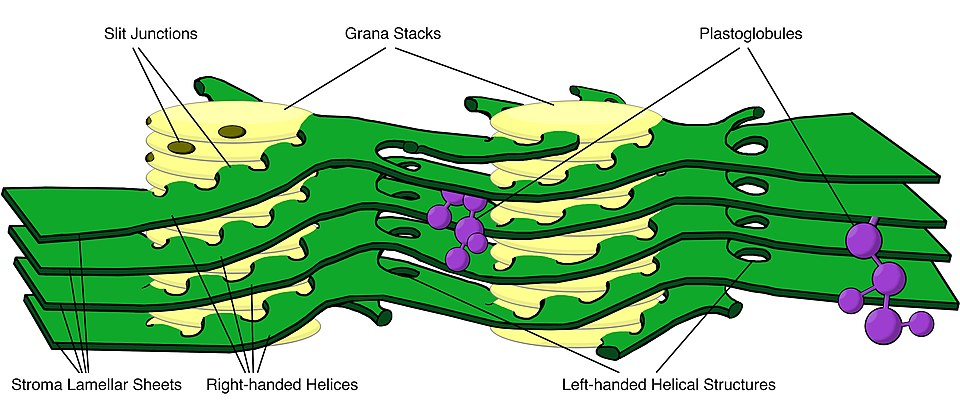

### References:
`Images and cryo-EM data`: Bussi, Y., Shimoni, E., Weiner, A., Kapon, R., Charuvi, D., Nevo, R., ... & Reich, Z. (2019). Fundamental helical geometry consolidates the plant photosynthetic membrane. Proceedings of the National Academy of Sciences, 116(44), 22366-22375.

# Install the required packages


In [1]:
#!pip install pyvista
#!pip install pyacvd
#!pip install trame trame-client trame-server trame-vtk
#!pip install trame-vuetify trame-components # Install UI components including vuetify
#!pip install trame-plotly trame-vega # Install additional packages that might be required
#!pip install MDAnalysis
#!pip install trimesh
#!pip install open3d

# Import the libraries

In [2]:
import pyvista as pv
import pyacvd
import matplotlib.pyplot as plt
import numpy as np
import trimesh
import math

# Load the Fucntions

In [3]:
def print_faces_area(mesh):
    """
    Print the statistics of the faces' area of a mesh.
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to analyze.
    Returns
    -------
    area : np.ndarray
        The area of the faces.
    """
    area = mesh.compute_cell_sizes().cell_data['Area']
    print(f"Number of faces: {area.size}")
    print(f"Mean area: {area.mean()}")
    print(f"Std area: {area.std()}")
    print(f"Min area: {area.min()}")
    print(f"Max area: {area.max()}")
    return area

#Function to plot the area histogram
def plot_area_histogram(list_area):
    """
    Compare the area of the faces of two meshes

    Parameters
    ----------
    list_area : list
        List of arrays containing the areas of the faces of two meshes
    ----------
    Returns
    -------
    None
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create histogram for each mesh
    for i, area in enumerate(list_area):
        ax.hist(area, bins=100, alpha=0.5, label=f'Mesh {i+1}')

    # Add labels and title
    ax.set_xlabel('Area')
    ax.set_ylabel('Frequency')
    ax.set_title('Area Histogram')
    ax.legend()

    # Show the plot
    plt.show()

def remesh_surface(mesh, n_points=20000, subdivision=1):
    """
    Remesh a surface to have more uniform triangle distribution using ACVD algorithm.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        Input mesh to be remeshed.
    
    n_points : int, default: 20000
        Target number of points for the remeshed surface.
    
    subdivision : int, default: 1
        Number of subdivisions to perform before clustering.
        Higher values create more input points for potentially better results.
    
    Returns
    -------
    pyvista.PolyData
        Remeshed surface with more uniform triangle distribution.
    
    Notes
    -----
    This function uses the Approximated Centroidal Voronoi Diagrams (ACVD)
    algorithm to create a more uniform triangulation of the input mesh.
    
    Examples
    --------
    >>> import pyvista as pv
    >>> from pyvista import examples
    >>> # Download example mesh
    >>> mesh = examples.download_cow()
    >>> # Remesh with 5000 points
    >>> uniform_mesh = remesh_surface(mesh, n_points=5000)
    """
    import pyacvd
    
    # Create the clustering object
    clus = pyacvd.Clustering(mesh)
    
    # Subdivide mesh for better clustering results if requested
    if subdivision > 1:
        clus.subdivide(subdivision)
    
    # Generate clusters
    clus.cluster(n_points)
    
    # Generate and return remeshed surface
    remeshed = clus.create_mesh()
    
    return remeshed

In [4]:
def simple_vertical_helix(height=10, radius=5, turns=3, n_points=100, handedness="right"):
    """
    Generate a simple vertical helix along the z-axis with specified handedness.

    Parameters
    ----------
    height : float, default: 10
        Total height of the helix.
        
    radius : float, default: 5
        Radius of the helix.
        
    turns : int or float, default: 3
        Number of complete turns in the helix.
        
    n_points : int, default: 100
        Number of points to generate along the helix.

    handedness : str, default: "right"
        Handedness of the helix. Must be either "right" or "left".
        Right-handed helix turns clockwise as it moves away from the viewer.
        Left-handed helix turns counter-clockwise as it moves away from the viewer.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the (x, y, z) coordinates 
        of points along the helix.
        
    Examples
    --------
    >>> # Create a right-handed helix (default)
    >>> points_right = simple_vertical_helix(height=10, radius=5, turns=3)
    >>> 
    >>> # Create a left-handed helix
    >>> points_left = simple_vertical_helix(height=10, radius=5, turns=3, handedness="left")
    """
    
    # Validate handedness parameter
    if handedness.lower() not in ["right", "left"]:
        raise ValueError("handedness must be either 'right' or 'left'")
    
    # Set handedness factor (1 for right-handed, -1 for left-handed)
    chirality = 1 if handedness.lower() == "right" else -1
    
    # Generate parameter space
    t = np.linspace(0, 1, n_points) #This creates a linear space from 0 to 1 with n_points points, e.g., [0, 0.01, ..., 1]
    theta = 2 * np.pi * turns * t # This creates a linear space from 0 to 2*pi*turns with n_points points e.g., [0, 0.0628, ..., 6.2832] for turns=3
    
    # Create helix coordinates
    x = radius * np.cos(theta) 
    y = chirality * radius * np.sin(theta)  # Chirality affects the y-coordinate
    z = height * t
    
    return np.column_stack((x, y, z)) 

def generate_helix_spline(x0=0, y0=0, z0=0, radius=1.0, pitch=2.0, turns=3.0, 
                         n_points=200, chirality='right'):
    """
    Generate a 3D helix spline starting from (x0, y0, z0).
    
    Parameters
    ----------
    x0, y0, z0 : float
        Starting coordinates
    radius : float
        Radius of the helix
    pitch : float
        Vertical distance per complete turn
    turns : float
        Number of complete turns
    n_points : int
        Number of points along the helix
    chirality : str
        Handedness of the helix ('right' or 'left')
    
    Returns
    -------
    points : np.ndarray
        Array of shape (n_points, 3) containing helix coordinates
    """
    # Parameter t goes from 0 to 2*pi*turns
    t = np.linspace(0, 2 * np.pi * turns, n_points)
    
    # Chirality factor: right-handed (+1) or left-handed (-1)
    chiral_factor = 1 if chirality.lower() == 'right' else -1
    
    # Helix equations
    x = x0 + radius * np.cos(t)
    y = y0 + chiral_factor * radius * np.sin(t)  # Chirality affects y component
    z = z0 + (pitch / (2 * np.pi)) * t
    
    # Stack into points array
    points = np.column_stack([x, y, z])
    return points


def plot_spline_helix(spline_points):
    """
    Plot the spline helix using matplotlib.

    Parameters
    ----------
    spline_points : np.ndarray
        Array of points representing the spline helix.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the spline helix
    ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2])
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

def create_elliptical_tube(spline_points, major_radius=1.0, minor_radius=0.5, n_points=20, 
                           align_to_global=True, closed=False):
    """
    Create a tube with elliptical cross-section around a set of spline points using Bishop frames.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    major_radius : float, default: 1.0
        Major radius of the elliptical cross-section.
        
    minor_radius : float, default: 0.5
        Minor radius of the elliptical cross-section.
        
    n_points : int, default: 20
        Number of points to use for each cross-section.
        
    align_to_global : bool, default: True
        Whether to align the major axis with the global coordinates when possible.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the elliptical tube.
    """
    import numpy as np
    import pyvista as pv
    
    # Calculate tangents and path lengths
    tangents = np.gradient(spline_points, axis=0)
    tangent_magnitudes = np.sqrt(np.sum(tangents**2, axis=1))
    tangents = tangents / tangent_magnitudes[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Create elliptical cross-section template
    theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    ellipse = np.column_stack((
        major_radius * np.cos(theta),
        minor_radius * np.sin(theta),
        np.zeros_like(theta)
    ))
    
    # Generate Bishop frame
    # Bishop frame minimizes rotation by removing the torsion component
    
    # Initialize reference frame
    t0 = tangents[0]
    
    # Choose reference vectors
    global_refs = [np.array([0, 0, 1]), np.array([1, 0, 0]), np.array([0, 1, 0])]
    
    # Find a reference vector that's not parallel to t0
    reference = global_refs[0]
    for ref in global_refs:
        if not np.isclose(np.abs(np.dot(t0, ref)), 1.0):
            reference = ref
            break
    
    # Create initial frame
    n0 = np.cross(t0, reference)
    n0 = n0 / np.linalg.norm(n0)
    b0 = np.cross(t0, n0)
    b0 = b0 / np.linalg.norm(b0)
    
    # Store frames
    frames = [(t0, n0, b0)]
    
    # Generate Bishop frames along the curve
    for i in range(1, len(spline_points)):
        t_prev, n_prev, b_prev = frames[-1]
        t_curr = tangents[i]
        
        # Transport the previous frame to current point
        # Compute the rotation from previous tangent to current tangent
        axis = np.cross(t_prev, t_curr)
        axis_norm = np.linalg.norm(axis)
        
        if axis_norm > 1e-10:
            # Rotation needed - tangent direction changed
            axis = axis / axis_norm
            cos_angle = np.dot(t_prev, t_curr)
            # Handle numerical issues
            if cos_angle > 1.0:
                cos_angle = 1.0
            elif cos_angle < -1.0:
                cos_angle = -1.0
            angle = np.arccos(cos_angle)
            
            # Apply Rodrigues rotation formula to n and b
            sin_angle = np.sin(angle)
            n_curr = n_prev * np.cos(angle) + \
                     np.cross(axis, n_prev) * sin_angle + \
                     axis * np.dot(axis, n_prev) * (1 - np.cos(angle))
                     
            b_curr = b_prev * np.cos(angle) + \
                     np.cross(axis, b_prev) * sin_angle + \
                     axis * np.dot(axis, b_prev) * (1 - np.cos(angle))
        else:
            # No rotation needed - tangent direction unchanged
            n_curr = n_prev
            b_curr = b_prev
        
        # Ensure orthogonality and unit length
        n_curr = n_curr - np.dot(n_curr, t_curr) * t_curr
        n_curr = n_curr / np.linalg.norm(n_curr)
        b_curr = np.cross(t_curr, n_curr)
        
        frames.append((t_curr, n_curr, b_curr))
    
    # Generate tube mesh
    for i, point in enumerate(spline_points):
        t, n, b = frames[i]
        
        # Create rotation matrix to orient ellipse
        rotation = np.column_stack((n, b, t))
        
        # Align major axis consistently if requested
        if align_to_global:
            # Try to align with global up when reasonable
            global_up = np.array([0, 0, 1])
            alignment = np.abs(np.dot(t, global_up))
            
            # If the tube is more horizontal than vertical
            if alignment < 0.7:  
                # Project global up onto the plane perpendicular to t
                proj_up = global_up - np.dot(global_up, t) * t
                norm_proj = np.linalg.norm(proj_up)
                
                if norm_proj > 1e-6:
                    # Use this as the new normal
                    n = proj_up / norm_proj
                    b = np.cross(t, n)
                    rotation = np.column_stack((n, b, t))
        
        # Transform ellipse points to this position
        for e in ellipse:
            # Rotate and translate ellipse point
            tube_points.append(point + np.dot(rotation, e))
        
        # Create faces between this circle and the previous one
        if i > 0:
            for j in range(n_points):
                idx1 = (i-1) * n_points + j
                idx2 = (i-1) * n_points + (j+1) % n_points
                idx3 = i * n_points + (j+1) % n_points
                idx4 = i * n_points + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested
    if closed and len(spline_points) > 2:
        # Connect last cross-section to first
        for j in range(n_points):
            idx1 = (len(spline_points)-1) * n_points + j
            idx2 = (len(spline_points)-1) * n_points + (j+1) % n_points
            idx3 = (j+1) % n_points
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])
    
    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points to use for each cross-section.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    
    # Calculate tangents and path lengths
    tangents = np.gradient(spline_points, axis=0)
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section template
    half_width = width / 2.0
    half_height = height / 2.0
    
    rectangle = np.array([
        [-half_width, -half_height, 0],
        [ half_width, -half_height, 0],
        [ half_width,  half_height, 0],
        [-half_width,  half_height, 0]
    ])
    
    # Generate tube mesh
    for i, point in enumerate(spline_points):
        t = tangents[i]
        
        # Create rotation matrix to orient rectangle along tangent
        rotation = np.eye(3)
        
        # Transform rectangle points to this position
        for e in rectangle:
            # Rotate and translate rectangle point
            tube_points.append(point + np.dot(rotation, e))
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(4):
                idx1 = (i-1) * 4 + j
                idx2 = (i-1) * 4 + (j+1) % 4
                idx3 = i * 4 + (j+1) % 4
                idx4 = i * 4 + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    # Close the loop if requested   
    if closed and len(spline_points) > 2:
        # Connect last cross-section to first
        for j in range(4):
            idx1 = (len(spline_points)-1) * 4 + j
            idx2 = (len(spline_points)-1) * 4 + (j+1) % 4
            idx3 = (j+1) % 4
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

def create_elliptical_helix(x0=0, y0=0, z0=0, radius_x=2.0, radius_y=1.0, 
                          pitch=2.0, turns=3.0, n_points=200, chirality='right'):
    """
    Create an elliptical helix spline with two different radii.
    
    Parameters
    ----------
    x0, y0, z0 : float
        Starting coordinates of the helix center.
        
    radius_x : float, default: 2.0
        Radius in the X direction (semi-major axis).
        
    radius_y : float, default: 1.0
        Radius in the Y direction (semi-minor axis).
        
    pitch : float, default: 2.0
        Vertical distance per complete turn.
        
    turns : float, default: 3.0
        Number of complete turns.
        
    n_points : int, default: 200
        Number of points along the helix.
        
    chirality : str, default: 'right'
        Handedness of the helix ('right' or 'left').
    
    Returns
    -------
    points : np.ndarray
        Array of shape (n_points, 3) containing elliptical helix coordinates.
    """
    # Parameter t goes from 0 to 2*pi*turns
    t = np.linspace(0, 2 * np.pi * turns, n_points)
    
    # Chirality factor: right-handed (+1) or left-handed (-1)
    chiral_factor = 1 if chirality.lower() == 'right' else -1
    
    # Elliptical helix equations
    x = x0 + radius_x * np.cos(t)
    y = y0 + chiral_factor * radius_y * np.sin(t)  # Different radius for elliptical shape
    z = z0 + (pitch / (2 * np.pi)) * t
    
    # Stack into points array
    points = np.column_stack([x, y, z])
    return points

In [5]:
def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    pv_mesh : pyvista.PolyData or list of pyvista.PolyData
        PyVista mesh(es) with material colors as point/cell data attributes.
        Returns single mesh if OBJ contains one object, list if multiple.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes if len(meshes) > 1 else meshes[0]
    
    else:
        # Single mesh
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return pv_mesh

In [6]:
def forbidden_cylinder(tree,mesh, center, radius, height):
    """
    Given a point, get all mesh points inside a cylinder around it.

    Parameters
    ----------
    tree : scipy.spatial.cKDTree
        KDTree for fast nearest neighbor search.
    mesh : pyvista.PolyData
        The mesh to analyze.
    center : np.ndarray
        The center point of the cylinder.
    radius : float
        The radius of the cylinder.
    height : float
        The height of the cylinder.
    Returns
    -------
    np.ndarray
        The indices of the points inside the cylinder.
    """
    # Calculate the search radius for pre-filtering
    # This is the radius of a sphere that contains the cylinder
    search_radius = np.sqrt(radius**2 + (height/2)**2)
    
    # Use KD-Tree to find all points within the search radius (fast pre-filtering)
    candidate_indices = tree.query_ball_point(center, search_radius)
    #print(f"Center: {center}")
    #print(f"Candidate indices: {candidate_indices}")

    # If no candidates found, return empty array
    if len(candidate_indices) == 0:
        return np.array([], dtype=int)

    return candidate_indices

def distribute_points_gaussian(mesh, n_points=100, mean_distance=21.2, std_distance=3.1, 
                               max_attempts=10000, forbiden_radius=11, forbiden_height=6, seed=None):
    """
    Distribute points on a mesh surface following a Gaussian nearest-neighbor distance distribution.
    
    Uses a modified Poisson disc sampling approach that targets distances from a Gaussian distribution.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        Mesh on which to distribute points.
        
    n_points : int, default: 100
        Number of points to distribute.
        
    mean_distance : float, default: 21.2
        Mean of the Gaussian nearest-neighbor distance distribution.
        
    std_distance : float, default: 3.1
        Standard deviation of the Gaussian nearest-neighbor distance distribution.
        
    max_attempts : int, default: 10000
        Maximum attempts to place each point.
        
    seed : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the distributed points.
    """
    import numpy as np
    import pyvista as pv
    from scipy.spatial import cKDTree
    
    #All points tree
    all_points_tree = cKDTree(mesh.points)

    # Set random seed if provided, it will be used in all random operations
    if seed is not None:
        np.random.seed(seed)
    
    # Generate target distances from Gaussian distribution
    target_distances = generate_nn_distances(n_points, mean_distance, std_distance)
    target_distances = np.sort(target_distances)  # Sort for better placement strategy
    
    # Initialize output points array
    points = np.zeros((n_points, 3))
    n_placed = 0
    
    # Place first point randomly on the surface
    random_idx = np.random.randint(mesh.n_points)
    points[0] = mesh.points[random_idx]
    n_placed = 1
    
    # Create KD-Tree for efficient nearest neighbor searches
    # The KD-Tree is a data structure that allows for fast nearest neighbor searches and has the structure of a binary tree
    # It is built from the points we have placed so far
    # We'll update this as we add points
    tree = cKDTree(points[:1]) #Start with the first point
    
    # Create a forbidden cylinder around the first point
    forbidden_points = forbidden_cylinder(all_points_tree, mesh, points[0], forbiden_radius, forbiden_height,
                                          )
    # Try to place remaining points
    for i in range(1, n_points):

        target_dist = target_distances[i-1]  # Use i-1 because we've placed 1 point already
        
        success = False
        for attempt in range(max_attempts):
            # Pick a random point on the mesh
            candidate_idx = np.random.randint(mesh.n_points)

            #Check if the index is in the forbidden points
            if candidate_idx in forbidden_points:
                continue

            candidate_point = mesh.points[candidate_idx]

            # Find distance to nearest existing point
            dist, _ = tree.query(candidate_point.reshape(1, -1))
            nearest_dist = dist[0]
            
            # Accept if it's close enough to our target distance
            # Use a tolerance that gets wider with more attempts
            tolerance = std_distance * (1.0 + attempt * 0.1)
            if abs(nearest_dist - target_dist) <= tolerance:
                points[n_placed] = candidate_point
                n_placed += 1
                
                # Update KD-Tree with new point
                tree = cKDTree(points[:n_placed])
                success = True

                # Create a new forbidden cylinder around the new point
                new_forbidden_points = forbidden_cylinder(all_points_tree, mesh, candidate_point, forbiden_radius, forbiden_height)

                if any(idx in forbidden_points for idx in new_forbidden_points):
                    continue  # Skip this candidate, it would create overlapping forbidden regions
                # Check if the new forbidden points exist, then we shouldn't place it there
                # Add the new forbidden points to the existing ones
                # Remove duplicates
                forbidden_points = np.unique(forbidden_points)
                print(len(forbidden_points))

                break
        
        # If we couldn't place this point after max_attempts, warn but continue
        if not success:
            print(f"Warning: Could not place point {i+1} after {max_attempts} attempts.")
            
            # Place a point anyway - pick a random surface point that's not too close to others
            for fallback_attempt in range(100):
                candidate_idx = np.random.randint(mesh.n_points)
                candidate_point = mesh.points[candidate_idx]
                dist, _ = tree.query(candidate_point.reshape(1, -1))
                
                # Accept if it's not too close to existing points
                if dist[0] > mean_distance * 0.5:
                    points[n_placed] = candidate_point
                    n_placed += 1
                    tree = cKDTree(points[:n_placed])
                    break
    
    # Analyze the resulting distribution
    if n_placed == n_points:
        # Calculate achieved NN distances
        tree = cKDTree(points)
        distances, _ = tree.query(points, k=2)
        achieved_distances = distances[:, 1]  # Second column is distance to nearest non-self neighbor
        
        # Print statistics
        print(f"Target distribution:  mean={mean_distance:.2f}, std={std_distance:.2f}")
        print(f"Achieved distribution: mean={np.mean(achieved_distances):.2f}, std={np.std(achieved_distances):.2f}")
    else:
        print(f"Warning: Only placed {n_placed} out of {n_points} points.")
    
    # Get positions of the forbidden points
    forbidden_points = mesh.points[forbidden_points]

    return points[:n_placed], forbidden_points


def analyze_point_distribution(points, target_mean=21.2, target_std=3.1):
    """
    Analyze the nearest-neighbor distance distribution of a set of points.
    
    Parameters
    ----------
    points : np.ndarray
        Array of shape (n_points, 3) containing point coordinates.
        
    target_mean : float, default: 21.2
        Target mean distance for comparison.
        
    target_std : float, default: 3.1
        Target standard deviation for comparison.
        
    Returns
    -------
    dict
        Dictionary containing distribution statistics and comparison metrics.
    """
    from scipy.spatial import cKDTree
    from scipy import stats
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate nearest neighbor distances
    tree = cKDTree(points)
    distances, _ = tree.query(points, k=2)
    nn_distances = distances[:, 1]  # Distances to nearest non-self neighbors
    
    # Calculate statistics
    actual_mean = np.mean(nn_distances)
    actual_std = np.std(nn_distances)
    
    # Generate target distribution for comparison
    n_points = len(points)
    target_distances = np.random.normal(target_mean, target_std, n_points)
    
    # Perform Kolmogorov-Smirnov test
    ks_statistic, ks_pvalue = stats.kstest(nn_distances, 'norm', 
                                           args=(target_mean, target_std))
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram of distances
    ax1.hist(nn_distances, bins=20, alpha=0.7, label='Actual')
    ax1.hist(target_distances, bins=20, alpha=0.5, label='Target')
    ax1.set_xlabel('Nearest Neighbor Distance')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distance Distribution Comparison')
    ax1.legend()
    
    # QQ plot
    stats.probplot(nn_distances, dist=stats.norm(loc=target_mean, scale=target_std), 
                  plot=ax2)
    ax2.set_title('Q-Q Plot vs. Target Gaussian')
    
    plt.tight_layout()
    
    # Return results
    results = {
        'actual_mean': actual_mean,
        'actual_std': actual_std,
        'target_mean': target_mean,
        'target_std': target_std,
        'ks_statistic': ks_statistic,
        'ks_pvalue': ks_pvalue,
        'nn_distances': nn_distances,
        'figure': fig
    }
    
    return results

In [7]:
def generate_nn_distances(n_points, mean=21.2, std=3.1, seed=None):
    """
    Generate random distances from a Gaussian distribution.

    Parameters
    ----------
    n_points : int
        Number of distances to generate.
        
    mean : float, default: 21.2
        Mean of the Gaussian distribution.
        
    std : float, default: 3.1
        Standard deviation of the Gaussian distribution.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_points,) containing the generated distances.
    """
    #Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std, size=n_points)

def plot_area_histogram(list_area):
    """
    Compare the area of the faces of two meshes

    Parameters
    ----------
    list_area : list
        List of arrays containing the areas of the faces of two meshes
    ----------
    Returns
    -------
    None
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create histogram for each mesh
    for i, area in enumerate(list_area):
        ax.hist(area, bins=100, alpha=0.5, label=f'Mesh {i+1}')

    # Add labels and title
    ax.set_xlabel('Area')
    ax.set_ylabel('Frequency')
    ax.set_title('Area Histogram')
    ax.legend()

    # Show the plot
    plt.show()

In [8]:
def parse_mtl_file(mtl_path):
    """Parse MTL file to extract material colors.
    
    Parameters
    ----------
    mtl_path : str
        Path to the MTL file.

    Returns
    -------
    materials : dict
        Dictionary mapping material names to their diffuse RGB colors.
    """
    materials = {}
    current_material = None
    
    with open(mtl_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('newmtl'):
                current_material = line.split()[1]
                materials[current_material] = {}
            elif line.startswith('Kd') and current_material:
                # Diffuse color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['diffuse'] = rgb
            elif line.startswith('Ka') and current_material:
                # Ambient color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['ambient'] = rgb
            elif line.startswith('Ks') and current_material:
                # Specular color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['specular'] = rgb
    
    return materials

def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    pv_mesh : pyvista.PolyData or list of pyvista.PolyData
        PyVista mesh(es) with material colors as point/cell data attributes.
        Returns single mesh if OBJ contains one object, list if multiple.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes if len(meshes) > 1 else meshes[0]
    
    else:
        # Single mesh
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return pv_mesh

def plot_mesh_with_materials(mesh, show_edges=True, window_size=[800, 600], background_color='white'):
    """Plot mesh with material colors.
    
    Parameters
    ----------
    mesh : pyvista.PolyData or list of pyvista.PolyData
        Mesh(es) to plot.
    show_edges : bool, default: True
        Whether to show mesh edges.
    window_size : list, default: [800, 600]
        Window size for the plotter.
    background_color : str or tuple, default: 'white'
        Background color for the scene.
    """
    plotter = pv.Plotter(window_size=window_size)
    plotter.background_color = background_color
    
    # Handle single mesh or list of meshes
    if not isinstance(mesh, list):
        mesh = [mesh]
    
    for pv_mesh in mesh:
        # Use material colors if available
        if 'material_color' in pv_mesh.array_names:
            colors = pv_mesh['material_color']
            plotter.add_mesh(pv_mesh, scalars=colors, rgb=True, show_edges=show_edges)
        elif 'face_colors' in pv_mesh.array_names:
            colors = pv_mesh['face_colors']
            plotter.add_mesh(pv_mesh, scalars=colors[:, :3], rgb=True, show_edges=show_edges)
        else:
            plotter.add_mesh(pv_mesh, color='lightblue', show_edges=show_edges)
    
    plotter.show()
    return plotter

In [9]:
def create_periodic_copies(mesh, n_copies_x_positive=1, n_copies_x_negative=1,
                           n_copies_y_positive=1, n_copies_y_negative=1,
                           n_copies_z_positive=1, n_copies_z_negative=1, 
                           x_limits=[], y_limits=[], z_limits=[]):
    """Create periodic copies of a mesh in the specified directions.
    
    Parameters
    ----------
    mesh : pyvista.PolyData or list of pyvista.PolyData
        The mesh(es) to copy.
    n_copies_x_positive : int, default: 1
        Number of copies in the positive x direction.
    n_copies_x_negative : int, default: 1
        Number of copies in the negative x direction.
    n_copies_y_positive : int, default: 1
        Number of copies in the positive y direction.
    n_copies_y_negative : int, default: 1
        Number of copies in the negative y direction.
    n_copies_z_positive : int, default: 1
        Number of copies in the positive z direction.
    n_copies_z_negative : int, default: 1
        Number of copies in the negative z direction.
    x_limits : list, default: []
        List of two floats specifying the x limits [xmin, xmax]. If empty, uses mesh bounds.
    y_limits : list, default: []
        List of two floats specifying the y limits [ymin, ymax]. If empty, uses mesh bounds.
    z_limits : list, default: []
        List of two floats specifying the z limits [zmin, zmax]. If empty, uses mesh bounds.
        
    Returns
    -------
    list of pyvista.PolyData
        List containing the original mesh and all periodic copies.
    """
    import pyvista as pv
    import numpy as np
    
    # Handle both single mesh and list of meshes
    if isinstance(mesh, list):
        mesh_list = mesh
    else:
        mesh_list = [mesh]
    
    # Calculate dimensions for translation
    if x_limits:
        x_min, x_max = x_limits
        x_size = x_max - x_min
    else:
        # Get bounds from all meshes
        all_bounds = []
        for m in mesh_list:
            all_bounds.append(m.bounds)
        all_bounds = np.array(all_bounds)
        x_min = all_bounds[:, 0].min()  # minimum x
        x_max = all_bounds[:, 1].max()  # maximum x
        x_size = x_max - x_min
    
    if y_limits:
        y_min, y_max = y_limits
        y_size = y_max - y_min
    else:
        y_min = all_bounds[:, 2].min()  # minimum y
        y_max = all_bounds[:, 3].max()  # maximum y
        y_size = y_max - y_min
    
    if z_limits:
        z_min, z_max = z_limits
        z_size = z_max - z_min
    else:
        z_min = all_bounds[:, 4].min()  # minimum z
        z_max = all_bounds[:, 5].max()  # maximum z
        z_size = z_max - z_min
    
    all_meshes = []
    
    # Generate all translation vectors
    for i in range(-n_copies_x_negative, n_copies_x_positive + 1):
        for j in range(-n_copies_y_negative, n_copies_y_positive + 1):
            for k in range(-n_copies_z_negative, n_copies_z_positive + 1):
                
                # Calculate translation vector
                translation = np.array([
                    i * x_size,
                    j * y_size,
                    k * z_size
                ])
                
                # Create copies of all meshes with this translation
                for original_mesh in mesh_list:
                    if i == 0 and j == 0 and k == 0:
                        # Original mesh (no translation)
                        all_meshes.append(original_mesh.copy())
                    else:
                        # Create translated copy using manual translation
                        translated_mesh = original_mesh.copy()
                        translated_mesh.points = translated_mesh.points + translation
                        all_meshes.append(translated_mesh)
    
    return all_meshes

def plot_periodic_copies(periodic_meshes, show_edges=False, window_size=[1600, 600], 
                        background_color='black', opacity=1.0):
    """Plot a list of periodic mesh copies.
    
    Parameters
    ----------
    periodic_meshes : list of pyvista.PolyData
        List of meshes to plot (typically output from create_periodic_copies).
    show_edges : bool, default: False
        Whether to show mesh edges.
    window_size : list, default: [1600, 600]
        Window size for the plotter.
    background_color : str or tuple, default: 'black'
        Background color for the scene.
    opacity : float, default: 1.0
        Opacity for all meshes (0.0 to 1.0).
        
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    import pyvista as pv
    
    plotter = pv.Plotter(window_size=window_size)
    plotter.background_color = background_color
    
    for mesh in periodic_meshes:
        # Use material colors if available
        if 'material_color' in mesh.array_names:
            colors = mesh['material_color']
            plotter.add_mesh(mesh, scalars=colors, rgb=True, show_edges=show_edges, 
                           opacity=opacity)
        elif 'face_colors' in mesh.array_names:
            colors = mesh['face_colors']
            plotter.add_mesh(mesh, scalars=colors[:, :3], rgb=True, show_edges=show_edges,
                           opacity=opacity)
        else:
            plotter.add_mesh(mesh, color='lightblue', show_edges=show_edges, 
                           opacity=opacity)
    
    plotter.show()
    return plotter

In [10]:
def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    list of pyvista.PolyData
        Always returns a list of PyVista mesh(es) with material colors as point/cell data attributes.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes  # Always return list
    
    else:
        # Single mesh - wrap in list
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return [pv_mesh]  # Always return list, even for single mesh

In [11]:
def cylinder_with_concentric_circles(radius=1.0, height=2.0, radial_resolution=16, 
                                        height_resolution=8, concentric_circles=3, 
                                        center=None, direction=None):
    """
    Generate a simple cylindrical mesh with concentric circles at the top and bottom.

    Parameters
    ----------
    radius : float, default: 1.0
        Radius of the cylinder.
    height : float, default: 2.0
        Height of the cylinder.
    radial_resolution : int, default: 16
        Number of radial segments (sides) of the cylinder.
    height_resolution : int, default: 8
        Number of segments along the height of the cylinder.
    concentric_circles : int, default: 3
        Number of concentric circles at the top and bottom of the cylinder.
    center : array_like, default: [0, 0, 0]
        Center point of the cylinder (middle point along the axis).
    direction : array_like, default: [0, 0, 1]
        Direction vector of the cylinder axis (will be normalized).
    """
    # Default values
    if center is None:
        center = np.array([0.0, 0.0, 0.0])
    else:
        center = np.array(center)
    
    if direction is None:
        direction = np.array([0.0, 0.0, 1.0])
    else:
        direction = np.array(direction)
    
    # Normalize direction vector
    direction = direction / np.linalg.norm(direction)
    
    # Create local coordinate system
    # Find two orthogonal vectors perpendicular to direction
    if abs(direction[2]) < 0.9:  # direction is not too close to z-axis
        u = np.cross(direction, [0, 0, 1])
    else:  # direction is close to z-axis, use x-axis instead
        u = np.cross(direction, [1, 0, 0])
    
    u = u / np.linalg.norm(u)
    v = np.cross(direction, u)
    v = v / np.linalg.norm(v)
    
    vertices = []
    
    # Calculate radii for concentric circles
    circle_radii = np.linspace(0, radius, concentric_circles + 1)[1:]  # Exclude center point
    
    # Create vertices for the cylindrical surface
    for i in range(height_resolution + 1):
        t = i / height_resolution  # Parameter from 0 to 1
        axis_pos = center + direction * (t - 0.5) * height  # Center cylinder on 'center'
        
        for j in range(radial_resolution):
            theta = 2 * np.pi * j / radial_resolution
            
            # Create point in local coordinate system
            local_x = radius * np.cos(theta)
            local_y = radius * np.sin(theta)
            
            # Transform to world coordinates
            world_pos = axis_pos + local_x * u + local_y * v
            vertices.append(world_pos)
    
    # Add cap vertices (top and bottom)
    for t in [0, 1]:  # Bottom (t=0) and top (t=1)
        axis_pos = center + direction * (t - 0.5) * height
        
        # Center point
        vertices.append(axis_pos)
        
        # Concentric circles
        for circle_radius in circle_radii:
            for j in range(radial_resolution):
                theta = 2 * np.pi * j / radial_resolution
                
                # Create point in local coordinate system
                local_x = circle_radius * np.cos(theta)
                local_y = circle_radius * np.sin(theta)
                
                # Transform to world coordinates
                world_pos = axis_pos + local_x * u + local_y * v
                vertices.append(world_pos)
    
    vertices = np.array(vertices)
    faces = []
    
    # Side faces
    for i in range(height_resolution):
        for j in range(radial_resolution):
            curr_base = i * radial_resolution
            next_base = (i + 1) * radial_resolution
            
            curr = curr_base + j
            next_j = curr_base + ((j + 1) % radial_resolution)
            next_i = next_base + j
            next_i_j = next_base + ((j + 1) % radial_resolution)
            
            faces.extend([3, curr, next_j, next_i])
            faces.extend([3, next_j, next_i_j, next_i])
    
    # Cap faces
    surface_vertices = (height_resolution + 1) * radial_resolution
    
    for cap_offset in [0, 1 + len(circle_radii) * radial_resolution]:  # Bottom and top caps
        center_idx = surface_vertices + cap_offset
        
        # Connect center to first ring
        first_ring_start = center_idx + 1
        for j in range(radial_resolution):
            curr = first_ring_start + j
            next_j = first_ring_start + ((j + 1) % radial_resolution)
            
            if cap_offset == 0:  # Bottom cap
                faces.extend([3, center_idx, next_j, curr])
            else:  # Top cap
                faces.extend([3, center_idx, curr, next_j])
        
        # Connect concentric rings
        for ring in range(len(circle_radii) - 1):
            inner_start = center_idx + 1 + ring * radial_resolution
            outer_start = center_idx + 1 + (ring + 1) * radial_resolution
            
            for j in range(radial_resolution):
                inner_curr = inner_start + j
                inner_next = inner_start + ((j + 1) % radial_resolution)
                outer_curr = outer_start + j
                outer_next = outer_start + ((j + 1) % radial_resolution)
                
                if cap_offset == 0:  # Bottom cap
                    faces.extend([3, inner_curr, inner_next, outer_curr])
                    faces.extend([3, inner_next, outer_next, outer_curr])
                else:  # Top cap
                    faces.extend([3, inner_curr, outer_curr, inner_next])
                    faces.extend([3, inner_next, outer_curr, outer_next])
    
    faces = np.array(faces)
    mesh = pv.PolyData(vertices, faces)
    mesh = mesh.clean()
    
    return mesh



def direction_vector(angle, axis='z', towards='x'):
    """
    Create a direction vector at a given angle from a specified axis.
    
    Parameters
    ----------
    angle : float
        Angle in degrees from the specified axis.
    axis : str, default: 'z'
        Reference axis ('x', 'y', or 'z') from which the angle is measured.
    towards : str, default: 'x'
        Direction to tilt towards ('x', 'y', or 'z'), must be different from axis.
        
    Returns
    -------
    np.ndarray
        Unit direction vector at the specified angle from the axis.
    """
    if axis == towards:
        raise ValueError("axis and towards must be different")
    
    angle_rad = np.radians(angle)
    
    if axis == 'z':
        if towards == 'x':
            return np.array([np.sin(angle_rad), 0, np.cos(angle_rad)])
        elif towards == 'y':
            return np.array([0, np.sin(angle_rad), np.cos(angle_rad)])
    
    elif axis == 'x':
        if towards == 'y':
            return np.array([np.cos(angle_rad), np.sin(angle_rad), 0])
        elif towards == 'z':
            return np.array([np.cos(angle_rad), 0, np.sin(angle_rad)])
    
    elif axis == 'y':
        if towards == 'x':
            return np.array([np.sin(angle_rad), np.cos(angle_rad), 0])
        elif towards == 'z':
            return np.array([0, np.cos(angle_rad), np.sin(angle_rad)])
    
    else:
        raise ValueError("axis must be 'x', 'y', or 'z'")

In [12]:
def select_random_points(mesh, n_points=10, seed=None):
    """
    Randomly select points from a mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to select points.
    
    n_points : int, default: 10
        Number of points to select.
        
    seed : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the coordinates of selected points.
    np.ndarray
        Array of shape (n_points,) containing the indices of selected points.
    """    
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Get total number of points in the mesh
    total_points = mesh.n_points
    
    # Ensure we don't try to select more points than available
    n_select = min(n_points, total_points)
    
    # Randomly select point indices
    selected_indices = np.random.choice(total_points, size=n_select, replace=False)
    
    # Get the coordinates of these points
    selected_points = mesh.points[selected_indices]
    
    return selected_points, selected_indices


def plot_mesh_with_highlighted_spheres(mesh, highlighted_points, 
                                      mesh_color='lightblue', point_color='red',
                                      point_size=15, mesh_opacity=1, show_edges=True,
                                      window_size=[800, 600], title="Mesh with Highlighted Points"):
    """
    Plot a mesh with specific points highlighted.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to plot.
        
    highlighted_points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of points to highlight.
        
    mesh_color : str or tuple, default: 'lightblue'
        Color for the mesh.
        
    point_color : str or tuple, default: 'red'
        Color for the highlighted points.
        
    point_size : int, default: 15
        Size of the highlighted points.
        
    mesh_opacity : float, default: 0.8
        Opacity of the mesh (0.0 to 1.0).
        
    show_edges : bool, default: True
        Whether to show edges of the mesh.
        
    window_size : list, default: [800, 600]
        Size of the plotting window [width, height].
        
    title : str, default: "Mesh with Highlighted Points"
        Title for the plot window.
    
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    # Create a plotter
    p = pv.Plotter(window_size=window_size)
    
    # Add the mesh
    p.add_mesh(mesh, 
               color=mesh_color, 
               show_edges=show_edges, 
               opacity=mesh_opacity)
    
    # Add the highlighted points
    #p.add_points(highlighted_points, 
    #             color=point_color, 
    #             point_size=point_size, 
    #             render_points_as_spheres=True)
    #Add spheres at the highlighted points
    for point in highlighted_points:
        p.add_mesh(pv.Sphere(radius=point_size, center=point), color=point_color)
    # Set a title
    p.add_text(title, font_size=16)
    
    # Show the plot
    p.show()
    
    return p

def plot_mesh_with_highlighted_points(mesh, highlighted_points, 
                                      mesh_color='lightblue', point_color='red',
                                      point_size=15, mesh_opacity=1, show_edges=True,
                                      window_size=[800, 600], title="Mesh with Highlighted Points"):
    """
    Plot a mesh with specific points highlighted.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to plot.
        
    highlighted_points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of points to highlight.
        
    mesh_color : str or tuple, default: 'lightblue'
        Color for the mesh.
        
    point_color : str or tuple, default: 'red'
        Color for the highlighted points.
        
    point_size : int, default: 15
        Size of the highlighted points.
        
    mesh_opacity : float, default: 0.8
        Opacity of the mesh (0.0 to 1.0).
        
    show_edges : bool, default: True
        Whether to show edges of the mesh.
        
    window_size : list, default: [800, 600]
        Size of the plotting window [width, height].
        
    title : str, default: "Mesh with Highlighted Points"
        Title for the plot window.
    
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    # Create a plotter
    p = pv.Plotter(window_size=window_size)
    
    # Add the mesh
    p.add_mesh(mesh, 
               color=mesh_color, 
               show_edges=show_edges, 
               opacity=mesh_opacity)
    
    # Add the highlighted points
    p.add_points(highlighted_points, 
                 color=point_color, 
                 point_size=point_size, 
                 render_points_as_spheres=False)

    
    # Show the plot
    p.show()
    
    return p

def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, width_resolution=4, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points along the spline to sample for cross-sections.
        
    width_resolution : int, default: 4
        Number of points per side of the rectangular cross-section.
        Higher values create smoother, more detailed cross-sections.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    from scipy.interpolate import interp1d
    
    # Resample spline to n_points if necessary
    if len(spline_points) != n_points:
        # Create parameter array for original points
        t_original = np.linspace(0, 1, len(spline_points))
        
        # Create interpolation functions for each coordinate
        interp_x = interp1d(t_original, spline_points[:, 0], kind='cubic')
        interp_y = interp1d(t_original, spline_points[:, 1], kind='cubic')
        interp_z = interp1d(t_original, spline_points[:, 2], kind='cubic')
        
        # Generate new parameter array with n_points
        t_new = np.linspace(0, 1, n_points)
        
        # Interpolate to get new points
        resampled_points = np.column_stack([
            interp_x(t_new),
            interp_y(t_new),
            interp_z(t_new)
        ])
    else:
        resampled_points = spline_points
    
    # Calculate tangents and normals
    tangents = np.gradient(resampled_points, axis=0)
    
    # Normalize tangents
    tangent_lengths = np.linalg.norm(tangents, axis=1)
    tangent_lengths[tangent_lengths == 0] = 1  # Avoid division by zero
    tangents = tangents / tangent_lengths[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section with specified resolution
    half_width = width / 2.0
    half_height = height / 2.0
    
    # Create rectangle points with width_resolution points per side in local 2D coordinates
    rectangle_2d = []
    
    # Bottom side: left to right
    for i in range(width_resolution):
        x = -half_width + (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, -half_height])
    
    # Right side: bottom to top (excluding corners already added)
    for i in range(1, width_resolution):
        y = -half_height + (i / (width_resolution - 1)) * height
        rectangle_2d.append([half_width, y])
    
    # Top side: right to left (excluding corners already added)
    for i in range(1, width_resolution):
        x = half_width - (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, half_height])
    
    # Left side: top to bottom (excluding corners already added)
    for i in range(1, width_resolution - 1):
        y = half_height - (i / (width_resolution - 1)) * height
        rectangle_2d.append([-half_width, y])
    
    rectangle_2d = np.array(rectangle_2d)
    points_per_section = len(rectangle_2d)
    
    # Generate tube mesh
    for i, center_point in enumerate(resampled_points):
        tangent = tangents[i]
        
        # Create local coordinate system at this point
        # Tangent is the Z-axis of local system
        local_z = tangent
        
        # Create a reasonable local X and Y axis
        # Choose an arbitrary vector not parallel to tangent
        if abs(local_z[2]) < 0.9:
            temp_vector = np.array([0, 0, 1])
        else:
            temp_vector = np.array([1, 0, 0])
        
        # Create local X axis (perpendicular to tangent)
        local_x = np.cross(local_z, temp_vector)
        local_x = local_x / np.linalg.norm(local_x)
        
        # Create local Y axis (perpendicular to both)
        local_y = np.cross(local_z, local_x)
        local_y = local_y / np.linalg.norm(local_y)
        
        # Create rotation matrix from local to global coordinates
        rotation_matrix = np.column_stack([local_x, local_y, local_z])
        
        # Transform rectangle points to 3D and orient them
        for local_point_2d in rectangle_2d:
            # Convert 2D rectangle point to 3D local coordinates
            local_point_3d = np.array([local_point_2d[0], local_point_2d[1], 0])
            
            # Rotate to global orientation and translate to center point
            global_point = center_point + np.dot(rotation_matrix, local_point_3d)
            tube_points.append(global_point)
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(points_per_section):
                idx1 = (i-1) * points_per_section + j
                idx2 = (i-1) * points_per_section + (j+1) % points_per_section
                idx3 = i * points_per_section + (j+1) % points_per_section
                idx4 = i * points_per_section + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested   
    if closed and len(resampled_points) > 2:
        # Connect last cross-section to first
        for j in range(points_per_section):
            idx1 = (len(resampled_points)-1) * points_per_section + j
            idx2 = (len(resampled_points)-1) * points_per_section + (j+1) % points_per_section
            idx3 = (j+1) % points_per_section
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))


In [13]:
def mesh_resolution(mesh):
    """
    Compute and print statistics for mesh face areas.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to analyze.
        
    Returns
    -------
    avg_area : float
        Average area of the mesh faces.
    std_area : float
        Standard deviation of the mesh face areas.
    """
    cell_sizes = mesh.compute_cell_sizes()
    avg_area = cell_sizes['Area'].mean()
    std_area = cell_sizes['Area'].std()
    
    print(f"The mesh has {mesh.n_faces} faces.")
    print(f"The average cell size is {avg_area:.2f} nm^2.")
    print(f"The standard deviation of the cell sizes is {std_area:.2f} nm^2.")
    
    return avg_area, std_area

In [14]:
def helix_pitch_from_tilt(radius, tilt_angle_deg):
    """
    Calculate the helix pitch (axial rise per full turn) 
    given its radius and tilt angle above the horizontal.

    Parameters:
        radius (float): Helix radius R.
        tilt_angle_deg (float): Tilt angle α above horizontal, in degrees.

    Returns:
        float: Pitch P (axial rise per full 360° turn).
    """
    alpha = math.radians(tilt_angle_deg)
    return 2 * math.pi * radius * math.tan(alpha)


def helix_radius_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the helix radius required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required helix radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))

def helix_radius_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the helix radius required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required helix radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))

# Global Variables

In [15]:
#wdir = '/Users/rubi/Documents/GitHub/Chloroplast'
wdir = '/martini/rubiz/Chloroplast'

# 🔵 1 Reference Cryo-EM data


The main components of the inner chloroplast membrane are:
- the **thylakoid stacks**  (`yellow`)
- the **right-handed helices**  (`blue`) around the stacks and connecting with the stroma and the left-handed helices
- the **left-handed helices**  (`purple`) stabilizing the right-handed helices and also connecting with the stacks and stroma.
- the **stroma**  (`green`) connecting with the left-handed and right-handed helices.

In [16]:
# Load mesh (.obj) and materials (.mtl)
obj_path = f"{wdir}/Reference_objs/original_merged.obj"
mtl_path = f"{wdir}/Reference_objs/original_merged.mtl"

# Load the meshes with materials
cryo_mesh = load_obj_with_materials(obj_path, mtl_path) 

In [17]:
# Scale the mesh by 10000 to convert to nm
for mesh in cryo_mesh:
    mesh.points *= 4000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
for mesh in cryo_mesh:
    mesh.rotate_x(90, inplace=True)

In [18]:
# Create a Plotter object
plot_cryo_mesh = pv.Plotter(window_size=[1600, 600])
plot_cryo_mesh.background_color = 'black'

# Add cryo_mesh
for mesh in cryo_mesh:
    colors = mesh['material_color']
    plot_cryo_mesh.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_cryo_mesh.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3925b5a50_0&reconnect=auto" class="pyvi…

### Different regions have a specific material name, we will assing an easy name to visualize them individually

In [19]:
dict_regions_materials = {
    'grana': 'Material.001',
    'stroma': 'Material.007',
    'left_handed': 'Material.002',
    'right_handed': 'Material.005',
}

In [20]:
# Renaming the materials
for region, material in dict_regions_materials.items():
    for mesh in cryo_mesh:
        mesh['region'] = region


dict_cryo_per_region = {}
for region, material in dict_regions_materials.items():
    # Filter meshes by material name
    filtered_meshes = [m for m in cryo_mesh if 'material_name' in m.array_names and 
                       np.any(m['material_name'] == material)]
    if filtered_meshes:
        dict_cryo_per_region[region] = filtered_meshes

        

## Visualizing the grana region

In [21]:
# Plot the grana region
plot_grana_cryo = pv.Plotter(window_size=[1600, 600])
plot_grana_cryo.background_color = 'black'

# Add grana meshes
for mesh in dict_cryo_per_region.get('grana', []):
    colors = mesh['material_color']
    plot_grana_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_grana_cryo.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3925b7a60_1&reconnect=auto" class="pyvi…

## Visualizing the right-handed helices

In [22]:
plot_r_helices_cryo = pv.Plotter(window_size=[1600, 600])
plot_r_helices_cryo.background_color = 'black'

# Add r_helices meshes
for mesh in dict_cryo_per_region.get('right_handed', []):
    colors = mesh['material_color']
    plot_r_helices_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_r_helices_cryo.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3925b5c90_2&reconnect=auto" class="pyvi…

## Visualizing the left-handed helices

In [23]:
plot_left_helices_cryo = pv.Plotter(window_size=[1600, 600])
plot_left_helices_cryo.background_color = 'black'

# Add left_helices meshes
for mesh in dict_cryo_per_region.get('left_handed', []):
    colors = mesh['material_color']
    plot_left_helices_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_left_helices_cryo.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be38729eda0_3&reconnect=auto" class="pyvi…

## Visualizing the stroma region

In [24]:
plot_stroma_cryo = pv.Plotter(window_size=[1600, 600])
plot_stroma_cryo.background_color = 'black'

# Add stroma meshes
for mesh in dict_cryo_per_region.get('stroma', []):
    colors = mesh['material_color']
    plot_stroma_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_stroma_cryo.show()


Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be38729f160_4&reconnect=auto" class="pyvi…

## Visualizing the right helices + left helices + stroma

In [25]:
plot_stroma_cryo = pv.Plotter(window_size=[1600, 600])
plot_stroma_cryo.background_color = 'black'

# Add stroma meshes
for mesh in dict_cryo_per_region.get('stroma', []) + dict_cryo_per_region.get('right_handed', []) + dict_cryo_per_region.get('left_handed', []):
    colors = mesh['material_color']
    plot_stroma_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_stroma_cryo.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be38729fc10_5&reconnect=auto" class="pyvi…

# 🔵 2 Reference Periodic model designed with Blender
A periodic model with Blender was designed to be able of reproducing the main features of the cryo-EM data.

In the following section, we will show how each component can be generated with PyVista.

The main components of the periodic model the are:
- the **thylakoid stacks**  (`yellow`)
- the **stroma + right-handed helices + left-handed helices**  (`green`).
- Everytime the regions intersect, a `slit-junction` was created (See illustration at the beggining of the Notebook).
- the **grey** and **white** regions were added to *cut* them an *open* the surfaces, they are not part of the model.


**Disadvantages**:
The main downside of this model is that the **mesh** density is not uniform and it is difficult to control.


In [26]:
# Load mesh with materials
obj_path = f"{wdir}/Reference_objs/periodic_model.obj"
mtl_path = f"{wdir}/Reference_objs/periodic_model.mtl"

# Load the mesh(es) - this now only returns the mesh data
periodic_manual_mesh = load_obj_with_materials(obj_path, mtl_path)

# Scale the mesh by 10000 to convert to nm
for mesh in periodic_manual_mesh:
    mesh.points *= 10000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
for mesh in periodic_manual_mesh:
    mesh.rotate_x(90, inplace=True)

dict_regions_materials_periodic = {
    'grana': 'Material.001',
    'stroma': 'Material.007',
    'upper_caps': 'Material.009',
    'lower_caps': 'Material.010',
}

# Renaming the materials
for region, material in dict_regions_materials_periodic.items():
    for mesh in periodic_manual_mesh:
        mesh['region'] = region


dict_periodic_per_region = {}
for region, material in dict_regions_materials_periodic.items():
    # Filter meshes by material name
    filtered_meshes = [m for m in periodic_manual_mesh if 'material_name' in m.array_names and 
                       np.any(m['material_name'] == material)]
    if filtered_meshes:
        dict_periodic_per_region[region] = filtered_meshes

# Plot grana and stroma regions
plot_periodic_manual_mesh = pv.Plotter(window_size=[1600, 600])
plot_periodic_manual_mesh.background_color = 'black'

# Add periodic_manual_mesh
for mesh in dict_periodic_per_region.get('grana', []) + dict_periodic_per_region.get('stroma', []):
    colors = mesh['material_color']
    plot_periodic_manual_mesh.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)
    

# Show the plot
plot_periodic_manual_mesh.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be38419f430_6&reconnect=auto" class="pyvi…

We will copy the periodic model in the z direction, using the limits of the model defined by the `z_min` and `z_max` variables (extracted from a lower_limits.obj and upper_limits.obj).

In [27]:
lower_limits_obj = trimesh.load(f"{wdir}/Reference_objs/lower_limits_periodic.obj")
upper_limits_obj = trimesh.load(f"{wdir}/Reference_objs/upper_limits.obj")

scale_factor = 3000  # Scale factor for conversion to mm
x_min = lower_limits_obj.vertices[:, 0].min()
x_max = upper_limits_obj.vertices[:, 0].max()
y_min = lower_limits_obj.vertices[:, 1].min()
y_max = upper_limits_obj.vertices[:, 1].max()
z_min = lower_limits_obj.vertices[:, 2].min()
z_max = upper_limits_obj.vertices[:, 2].max()


### Adding periodic copies



In [28]:
# Create periodic copies
# This will create a 3x3 mesh

periodic_copies = create_periodic_copies(
    periodic_manual_mesh,
    n_copies_x_positive=1,
    n_copies_x_negative=1,
    n_copies_y_positive=4,
    n_copies_y_negative=4,
    n_copies_z_positive=0,
    n_copies_z_negative=0,
    x_limits=[x_min, x_max],
    y_limits=[y_min, y_max],
    z_limits=[z_min, z_max]
)

dict_periodic_copies_per_region = {}
for region, material in dict_regions_materials_periodic.items():
    # Filter meshes by material name
    filtered_meshes = [m for m in periodic_copies if 'material_name' in m.array_names and 
                       np.any(m['material_name'] == material)]
    if filtered_meshes:
        dict_periodic_copies_per_region[region] = filtered_meshes

        

## Visualize the periodic grana

In [29]:
# Plot them
#New plotter for periodic copies

# Create a single plotter and add both meshes
periodic_plot = pv.Plotter(window_size=[1600, 600])
periodic_plot.background_color = 'black'

for mesh in dict_periodic_copies_per_region.get('grana', []) + dict_periodic_copies_per_region.get('stroma', []):
    colors = mesh['material_color']
    periodic_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

periodic_plot.show()


Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3843fb310_7&reconnect=auto" class="pyvi…

In [30]:
# Plot them
#New plotter for periodic copies

# Create a single plotter and add both meshes
periodic_grana_plot = pv.Plotter(window_size=[1600, 600])
periodic_grana_plot.background_color = 'black'

for mesh in dict_periodic_copies_per_region.get('grana', []):
    colors = mesh['material_color']
    periodic_grana_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

periodic_grana_plot.show()


Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3843dfb50_8&reconnect=auto" class="pyvi…

## Visualizing the periodic stroma merged with the right-handed and left-handed helices

In [31]:
# Plot them
#New plotter for periodic copies

# Create a single plotter and add both meshes
periodic_stroma_plot = pv.Plotter(window_size=[1600, 600])
periodic_stroma_plot.background_color = 'black'

for mesh in dict_periodic_copies_per_region.get('stroma', []):
    colors = mesh['material_color']
    periodic_stroma_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

periodic_stroma_plot.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3843dea10_9&reconnect=auto" class="pyvi…

# 🔵 3 Building the periodic model with PyVista

## 🟡 Grana stacks 

We will build grana stacks with a diameter of 200 nm and thickness of 10 nm, separated by 40 nm and compare the with the cryo-EM data.

We will visualize the original cryo-EM data to compare our simplified model.

#### Create a high-resolution cylinder with uneven faces

In [32]:
#---*** USER DEFINED VARIABLES ***---
# VARIABLE FOR INDIVIDUAL CYLINDER MESHES
radius_granum = 125                  # Radius of the cylinder in nm
height_granum = 20                   # Height of the cylinder in nm
radial_resolution = 1080            # Number of radial segments in the caps of the cylinder
height_resolution = height_granum * 10     # Number of segments along the height
concentric_circles = radius_granum * 10    # Number of concentric circles at the top and bottom of the cylinder
center = [0, 0, 0]                  # Center point of the cylinder
direction = [0, 0, 1]               # Direction vector of the cylinder axis

# VARIABLES FOR FULL STACKS
n_granum = 20
granum_separation = 20

#---*** END USER DEFINED VARIABLES ***---

In [33]:
# Set REWRITE_CYLINDER = True to regenerate the mesh (time-consuming ~2min per 2x10^6 faces)
REWRITE_CYLINDER = False
if REWRITE_CYLINDER:
    cylinder_mesh = cylinder_with_concentric_circles(radius=radius_granum, height=height_granum/2, radial_resolution=radial_resolution,
                                        height_resolution=height_resolution, concentric_circles=concentric_circles, center=center, direction=direction).triangulate()

    #---INFO---
    area_cylinder = (2* np.pi * radius_granum**2) + (2 * np.pi * radius_granum * height_granum) 
    print(f"Total area of the cylinder: {area_cylinder:.2f} nm^2")
    n_faces = cylinder_mesh.n_faces_strict
    print(f"The mesh has {n_faces} faces.")



#### Modify the Cylinder to create an even face distribution

In [34]:
# Set REWRITE_CYLINDER = True one cell above to regenerate the mesh (time-consuming ~1min per 10^6 faces)

if REWRITE_CYLINDER:
    #---*** USER DEFINED VARIABLES ***---
    number_of_faces = 500000 # Magic number, approximate number of faces in the remeshed cylinder
    #---*** END OF USER DEFINED VARIABLES ***---

    #---CLustering and remeshing
    clus = pyacvd.Clustering(cylinder_mesh)
    clus.cluster(number_of_faces)
    remesh = clus.create_mesh()

    # Clean the remeshed mesh to remove any duplicate points or faces
    remesh = remesh.clean()

    #---INFO---
    n_faces_remeshed = remesh.n_faces
    print(f"The remeshed mesh has {n_faces_remeshed} faces.")
    cell_sizes = remesh.compute_cell_sizes()
    avg_area = cell_sizes['Area'].mean()
    print(f"The average cell size in the remeshed mesh is {avg_area:.2f} nm^2.")
    std_area = cell_sizes['Area'].std()
    print(f"The standard deviation of the cell sizes in the remeshed mesh is {std_area:.2f} nm^2.")



#### Save a low and high-resolution cylinder as .obj files

In [35]:
# Set REWRITE_CYLINDER = True two cells above to regenerate the mesh
if REWRITE_CYLINDER:
    #---Save the high-resolution cylinder as an OBJ file
    output_obj_path = f"{wdir}/Reference_objs/cylinder.obj"
    remesh.save(output_obj_path)

    #---Decimate the mesh to reduce the number of faces 
    decimated_cylinder = remesh.decimate(0.95)  # Reduce to 5% of the original

    #---Save the decimated mesh as an OBJ file
    output_obj_path = f"{wdir}/Reference_objs/cylinder_decimated.obj"
    decimated_cylinder.save(output_obj_path)

#### Load the high-resolution cylinder

In [36]:
# Read the decimated mesh
output_obj_path = f"{wdir}/Reference_objs/cylinder.obj"
cylinder_mesh_loaded = pv.read(output_obj_path) 

In [37]:
cylinder_plot = pv.Plotter(window_size=[1800, 600])
cylinder_plot.background_color = 'white'
cylinder_plot.add_mesh(cylinder_mesh_loaded, color='yellow', show_edges=True)
cylinder_plot.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be384479f30_10&reconnect=auto" class="pyv…

### Load low-resolution cylinder

In [38]:
# Read the decimated mesh
output_obj_path = f"{wdir}/Reference_objs/cylinder_decimated.obj"
decimated_cylinder = pv.read(output_obj_path)

#---INFO---
print(f"High-resolution mesh has {cylinder_mesh_loaded.n_faces} faces.")
print(f"Low resolution mesh has {decimated_cylinder.n_faces} faces.")

High-resolution mesh has 999996 faces.
Low resolution mesh has 49998 faces.


/martini/rubiz/Chloroplast/env/lib/python3.10/site-packages/pyvista/core/pointset.py:1386: PyVistaDeprecationWarning: The current behavior of `pv.PolyData.n_faces` has been deprecated.
                Use `pv.PolyData.n_cells` or `pv.PolyData.n_faces_strict` instead.
                See the documentation in '`pv.PolyData.n_faces` for more information.
  warnings.warn(


#### Fitting the stacks to the Cryo-EM data

In [39]:
#--- Get reference information
first_stack = dict_cryo_per_region.get('grana', [])[0]
reference_center = np.array(first_stack.center)
z_offset = reference_center[2] + (10 * granum_separation)  # Offset to position the first cylinder above the reference center
reference_center[2] = z_offset  # Update the reference center to the new z position

#--- Create an array with n_cylinders separated by a given distance
grana_20_cylinders = []
for j in range(n_granum): # Loop over the number of cylinders in the z direction
    # Calculate the position for each cylinder
    cylinder_center = np.array([
        reference_center[0],  # Keep the x position constant
        reference_center[1],  # Keep the y position constant
        reference_center[2] - (j * granum_separation)  # Move along z-axis
    ])
    
    # Create a copy of the decimated mesh and position it
    cylinder_copy = decimated_cylinder.copy()
    # Translate from original center to new position
    cylinder_copy.points += cylinder_center - decimated_cylinder.center

    grana_20_cylinders.append(cylinder_copy)



#### Plot the grana vs the cryo-EM data

We can see that the radius and the height chosen approximate the cryo-EM grana, especially the ones at the bottom. However, the original grana have ~5 degree inclination that is not taken into account as the periodicity will be harder to achieve. 

In [40]:
#--- Plot the cylinders
grana_plot = pv.Plotter(window_size=[1800, 600])
grana_plot.background_color = 'white'
for cylinder in grana_20_cylinders:
    # Add the translated cylinder to the plotter
    grana_plot.add_mesh(cylinder, color='yellow', show_edges=False)

# Add the cryo-mesh for context
for mesh in dict_cryo_per_region.get('grana', []):
    colors = mesh['material_color']
    grana_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show axes
grana_plot.show_axes()
# Show the plot
grana_plot.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3843f9a50_11&reconnect=auto" class="pyv…

In [41]:
# Combine the cylinders into a single mesh
combined_grana_cylinders = grana_20_cylinders[0].copy()
for cylinder in grana_20_cylinders[1:]:
    combined_grana_cylinders += cylinder

#Center the mesh at the origin
combined_grana_cylinders.points -= combined_grana_cylinders.center



## 🟡 Right-handed helices

#### Loading reference cryo-EM helix

To simply evaluate our model, we will load the best looking helix.

In [42]:
#---Load the meshes with materials---
obj_path = f"{wdir}/Reference_objs/reference_right_handed_helix.obj"
mtl_path = f"{wdir}/Reference_objs/reference_right_handed_helix.mtl"        
reference_right_helix = load_obj_with_materials(obj_path, mtl_path)[0]

#---Pre-processing---
# Scale by 4000 to convert to nm
reference_right_helix.points *= 4000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
reference_right_helix.rotate_x(90, inplace=True)

# Center the mesh at the origin
reference_right_helix.points -= reference_right_helix.center

#---Plot---
# Create a Plotter object
plot_reference_right_helix = pv.Plotter(window_size=[1600, 600])
plot_reference_right_helix.background_color = 'black'

# Add reference_right_helix
colors = reference_right_helix['material_color']
plot_reference_right_helix.add_mesh(reference_right_helix, scalars=colors, rgb=True, show_edges=False)

# Show axes and origin
plot_reference_right_helix.show_axes()

# Show the plot
plot_reference_right_helix.show()

Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be3843df7c0_12&reconnect=auto" class="pyv…

In [43]:
###---USER DEFINED VARIABLES---###
tilt_angle_right = 15.9  # Desired tilt angle in degrees
radius_granum = 125
###---END OF USER DEFINED VARIABLES---###

###---AUTO GENERATED VARIABLES---###
r_spline_right = radius_granum + (height_granum)                   # Radius of the spline in the x direction (nm)
# Note: helix_pitch_from_tilt function needs to be defined
# pitch_right = helix_pitch_from_tilt(r_spline_right, tilt_angle_right)
# For now, using a placeholder calculation
pitch_right = helix_pitch_from_tilt(r_spline_right, tilt_angle_right)  # Pitch of the helix (nm)

rz_inner_right = height_granum / 2                                             # Inner helix radius in the z direction (nm) 
rxy_inner_right = height_granum                                           # Outer helix radius parallel to the xy plane (nm)
rxy_spline_right_helix = r_spline_right                                      # Radius of the spline in the xy plane (nm)
total_height_stacks = n_granum * (granum_separation + height_granum) - granum_separation   # Total height of the stacks (nm)
n_turns_right_helix = total_height_stacks / pitch_right                       # Total number of turns in the helix
height_spline_right_helix = (pitch_right * n_turns_right_helix) - (2 * rz_inner_right)           # Height of the spline in the z direction (nm)

total_radius_right_helix = rxy_spline_right_helix + rxy_inner_right                # Total radius of the helix (nm)
total_height_right_helix = height_spline_right_helix + (2 * rz_inner_right) 
###---END OF AUTO GENERATED VARIABLES---###

#---INFO---
print(f"Total height of the stacks: {total_height_stacks:.2f} nm")
print(f"Total number of turns in the helix: {n_turns_right_helix:.2f}")
print(f"Height of the spline in the z direction: {height_spline_right_helix:.2f} nm")
print(f"Radius of the spline in the x direction: {rxy_spline_right_helix:.2f} nm")
print(f"Total radius of the helix: {total_radius_right_helix:.2f} nm")
print(f"Total height of the helix: {total_height_right_helix:.2f} nm")


Total height of the stacks: 780.00 nm
Total number of turns in the helix: 3.01
Height of the spline in the z direction: 760.00 nm
Radius of the spline in the x direction: 145.00 nm
Total radius of the helix: 165.00 nm
Total height of the helix: 780.00 nm


In [44]:
#Starting point is the point with the lowest z-coordinate
init_point = reference_right_helix.points[reference_right_helix.points[:, 2].argmin()]
height_reference_right_helix = reference_right_helix.points[:, 2].max() - reference_right_helix.points[:, 2].min()
print(f"Initial point of the helix: {init_point}")
print(f"Height of the reference right-handed helix: {height_reference_right_helix:.2f} nm") 
# Generate a helix path (Note that n_points also counts the start and end points)
helix_points = generate_helix_spline(x0=0, y0=init_point[1], z0=init_point[2], radius=r_spline_right, pitch=pitch_right, turns=n_turns_right_helix, 
                         n_points=501, chirality='right')

# Create elliptical tube around the path
tube_mesh = create_elliptical_tube(
    helix_points, 
    major_radius=rz_inner_right, 
    minor_radius=rxy_inner_right, 
    n_points=1001 # Number of points in the cross-section
)

tube_mesh = create_rectangular_tube(
    helix_points, 
    width=2 * rxy_inner_right, 
    height=2 * rz_inner_right, 
    n_points=101, 
    width_resolution=20,  # Number of points per side of the rectangular cross-section
    closed=False
)

avg_area, std_area = mesh_resolution(tube_mesh)

#Center the tube mesh at the origin
#tube_mesh.points -= tube_mesh.center

# Create a Plotter object
plot_tube_helix = pv.Plotter(window_size=[1600, 600])
plot_tube_helix.background_color = 'white'
# Add the tube mesh
plot_tube_helix.add_mesh(tube_mesh, show_edges=True, color='lightblue')
# Add the reference right-handed helix mesh for comparison
plot_tube_helix.add_mesh(reference_right_helix, show_edges=False, color='blue')
# Show axes and origin
plot_tube_helix.show_axes()
# Show the plot
plot_tube_helix.show()


Initial point of the helix: [ 146.31  -138.554 -151.916]
Height of the reference right-handed helix: 303.83 nm
The mesh has 15200 faces.
The average cell size is 22.39 nm^2.
The standard deviation of the cell sizes is 7.70 nm^2.


Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be38447b610_13&reconnect=auto" class="pyv…

In [45]:
#Print the resolution of the tube mesh
print(f"The tube mesh has {tube_mesh.n_faces} faces.")
  
avg_area = tube_mesh.compute_cell_sizes()['Area'].mean()
std_area = tube_mesh.compute_cell_sizes()['Area'].std()

print(f"The total avg and std area of the tube mesh are {avg_area:.2f} nm^2 and {std_area:.2f} nm^2, respectively.")


The tube mesh has 15200 faces.
The total avg and std area of the tube mesh are 22.39 nm^2 and 7.70 nm^2, respectively.


#### Adding copies every 120 degrees

In [51]:
#--- Get reference information
theta_0 = 0
point_0 = [0,radius_granum,0]
#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)
helix_points = generate_helix_spline(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius=rxy_spline_right_helix+(rxy_inner_right*1.5), pitch=pitch_right, turns=n_turns_right_helix, 
                         n_points=101, chirality='right')

# Create elliptical tube around the path
#tube_mesh = create_elliptical_tube(
#    helix_points, 
#    major_radius=rz_inner_right,
#    minor_radius=rxy_inner_right*3,
#    n_points=101 # Number of points in the cross-section
#)

tube_mesh = create_rectangular_tube(
    helix_points, 
    width=2 * rxy_inner_right*3, 
    height=2 * rz_inner_right, 
    n_points=101, 
    width_resolution=20,  # Number of points per side of the rectangular cross-section
    closed=False
)

# Center the tube mesh at the origin
tube_mesh.points -= tube_mesh.center

right_helix_4 = []
n_right_helices = 4  # Number of right-handed helices
for j in range(n_right_helices): # Loop over the number of cylinders in the z direction

    #Rotate the tube mesh around the z-axis
    rotated_tube = tube_mesh.copy()
    rotated_tube.rotate_z(theta_0, inplace=True)
    right_helix_4.append(rotated_tube)
    theta_0 += 90

combined_right_handed_helices = right_helix_4[0].copy()
for helix in right_helix_4[1:]:
    combined_right_handed_helices += helix

# Big helix (stroma) with tilt algle close to zero
tilt_angle_right_big = 0.5
radius = helix_radius_from_tilt(pitch_left, tilt_angle_right_big)  # Calculate the radius for the big helix

# Generate right-handed helix path with a smaller tilt angle
helix_points_big = generate_helix_spline(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius=radius, pitch=pitch_right, turns=int(n_turns_right_helix), 
                         n_points=101, chirality='right')
# Create elliptical tube around the path for the big helix
tube_mesh_big = create_elliptical_tube(
    helix_points_big, 
    major_radius=rz_inner_right,
    minor_radius=9*radius_granum - 4*height_granum,
    n_points=20 # Number of points in the cross-section
)

# Center the tube mesh at the origin
tube_mesh_big.points -= tube_mesh_big.center

# Rotate 90 degrees around the z-axis
#tube_mesh_big.rotate_z(45, inplace=True)

right_helix_big = []
theta_0 = 0
n_right_helices_big = 4  # Number of right-handed helices
for j in range(n_right_helices_big): # Loop over the number of cylinders in the
    # Rotate the tube mesh around the z-axis
    rotated_tube_big = tube_mesh_big.copy()
    rotated_tube_big.rotate_z(theta_0, inplace=True)
    right_helix_big.append(rotated_tube_big)
    theta_0 += 90
combined_right_handed_helices_big = right_helix_big[0].copy()
for helix in right_helix_big[1:]:
    combined_right_handed_helices_big += helix

# Save only the cell between the bounds
limit=250
combined_right_handed_helices_big = combined_right_handed_helices_big.clip_box(bounds=[-limit, limit, -limit, limit, -100, 100], invert=False)

# Duplicate in the x and y directions to create a periodic structure
combined_right_handed_helices_big2 = combined_right_handed_helices_big.copy()
# Translate the mesh in the x and y directions
combined_right_handed_helices_big2.points[:, 0] += 2 * limit
#--- Plot the right-handed helix 
right_helix_plot = pv.Plotter(window_size=[1800, 600])
right_helix_plot.background_color = 'black'
#right_helix_plot.add_mesh(combined_right_handed_helices, color='blue', show_edges=False)
right_helix_plot.add_mesh(combined_right_handed_helices_big, color='lightblue', show_edges=False)
right_helix_plot.add_mesh(combined_right_handed_helices_big2, color='yellow', show_edges=False)
#right_helix_plot.add_mesh(combined_grana_cylinders, color='yellow', show_edges=False)
#right_helix_plot.add_mesh(combined_pitch_boxes, color='red', show_edges=False)
right_helix_plot.show()







Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be38447bca0_16&reconnect=auto" class="pyv…

## First periodic model: Grana + right-handed helix

In [ ]:
# Get bounds stacks 
bounds_stacks = combined_grana_cylinders.bounds

lower_bounds_stacks = np.array([bounds_stacks[0], bounds_stacks[2], bounds_stacks[4]])
upper_bounds_stacks = np.array([bounds_stacks[1], bounds_stacks[3], bounds_stacks[5]])

#zi = height_granum +1
#zf = (height_granum + granum_separation)
zi = height_granum + (granum_separation/2)
zf = zi + (1.5 * (height_granum + granum_separation) ) + (granum_separation/2)  # 3 stacks + 2 caps
lower_bounds_stacks = np.array([lower_bounds_stacks[0], lower_bounds_stacks[1], zi])
upper_bounds_stacks = np.array([upper_bounds_stacks[0], upper_bounds_stacks[1], zf])

#---INFO---
print(f"Lower bounds of the stacks: {lower_bounds_stacks}")
print(f"Upper bounds of the stacks: {upper_bounds_stacks}")

#Filter the points that are within zi and zf
# Get cell centers directly using PyVista's method
cell_centers = combined_grana_cylinders.cell_centers().points

# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi 
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_grana = combined_grana_cylinders.extract_cells(cell_ind)

# Subgrid right-handed helices
cell_centers = combined_right_handed_helices.cell_centers().points
# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_right_helices = combined_right_handed_helices.extract_cells(cell_ind)

# Plot 3 copies
periodic_grana_plot = pv.Plotter(window_size=[1800, 600])
periodic_grana_plot.background_color = 'white'
periodic_grana_plot.add_mesh(subgrid_grana, color='yellow', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.add_mesh(subgrid_right_helices, color='blue', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.show()


## 🟡 Left-handed helices

In [ ]:
#---Load the meshes with materials---
obj_path = f"{wdir}/Reference_objs/reference_left_handed_helix.obj"
mtl_path = f"{wdir}/Reference_objs/reference_left_handed_helix.mtl"        
reference_left_helix = load_obj_with_materials(obj_path, mtl_path)[0]

#---Pre-processing---
# Scale by 4000 to convert to nm
reference_left_helix.points *= 4000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
reference_left_helix.rotate_x(90, inplace=True)

# Center the mesh at the origin
reference_left_helix.points -= reference_left_helix.center

#---Plot---
# Create a Plotter object
plot_reference_left_helix = pv.Plotter(window_size=[1600, 600])
plot_reference_left_helix.background_color = 'black'

# Add reference_left_helix
colors = reference_left_helix['material_color']
plot_reference_left_helix.add_mesh(reference_left_helix, scalars=colors, rgb=True, show_edges=False)

# Show axes and origin
plot_reference_left_helix.show_axes()

# Show the plot
plot_reference_left_helix.show()

In [47]:
###---USER DEFINED VARIABLES---###
rz_inner_left = height_granum/2              
inner_pore = 25                                # Inner helix radius in the z direction (nm) 
rxy_inner_left = height_granum/2                                            # Outer helix radius parallel to the xy plane (nm)
pitch_left = pitch_right/4 
#tilt_angle_left = 16.6  # Desired tilt angle in degrees      
tilt_angle_left = tilt_angle_right          # Height pitch the left-handed helix (nm)
d_left_helix = helix_radius_from_tilt(pitch_left, tilt_angle_left)                               # Distance between the center of the granum and the center of the helix (nm)
d_granum_helix = radius_granum + (3 * height_granum) + inner_pore # Distance between the center of the granum and the center of the helix (nm)
###---END OF USER DEFINED VARIABLES---###

###---AUTO GENERATED VARIABLES---###

n_turns_left_helix = total_height_right_helix / pitch_left     # Total number of turns in the helix
rz_spline_left_helix = (pitch_left * n_turns_left_helix) - (2 * rz_inner_left)           # Height of the spline in the z direction (nm)
rxy_spline_left_helix =  height_granum/2 + inner_pore                    # Radius of the spline in the x direction (nm)
total_height_helix = rz_spline_left_helix + (2 * rz_inner_left) 
###---END OF AUTO GENERATED VARIABLES---###

#---INFO---
print(f"Total height of the stacks: {total_height_right_helix:.2f} nm")
print(f"Total number of turns in the helix: {n_turns_left_helix:.2f}")
print(f"Height of the spline in the z direction: {rz_spline_left_helix:.2f} nm")
print(f"Radius of the spline in the x direction: {rxy_spline_left_helix:.2f} nm")
print(f"Total radius of the helix: {d_left_helix:.2f} nm")
print(f"Total height of the helix: {total_height_helix:.2f} nm")


Total height of the stacks: 780.00 nm
Total number of turns in the helix: 12.02
Height of the spline in the z direction: 760.00 nm
Radius of the spline in the x direction: 35.00 nm
Total radius of the helix: 36.25 nm
Total height of the helix: 780.00 nm


# 🟡 CONE

In [ ]:
def radius_cone_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the radius of a cone required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required cone radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))

In [ ]:
radius_cone = radius_cone_from_tilt(pitch_left/2, tilt_angle_left) 
print(f"Radius of the cone: {radius_cone:.2f} nm")
print(f"Pitch of the left-handed helix: {pitch_left:.2f} nm")
mesh2 = pv.Cone(radius=radius_cone*2, height=height_granum/2, capping=False, direction=[0, 0, 1], center=[0, 0, 0],resolution=10)

# Subdivide
#mesh2 = mesh2.subdivide(5)  # Subdivide the cone mesh to increase resolution

# Calculate the resolution of the mesh
avg_area, std_area = mesh_resolution(mesh2)
print(f"The cone mesh has {mesh2.n_faces} faces.")

#mesh.plot(show_edges=True, color='red')
mesh2.plot(show_edges=True, color='blue')

Initial point of the left-handed helix: [0, 235, -390.0]
Pitch of the left-handed helix: 64.88 nm
Pitch positions: [-357.55964994 -292.55964994 -227.55964994 -162.55964994  -97.55964994
  -32.55964994   32.44035006   97.44035006  162.44035006  227.44035006
  292.44035006  357.44035006  422.44035006]
Pitch positions (with thickness): [-380. -315. -250. -185. -120.  -55.   10.   75.  140.  205.  270.  335.
  400.]
Pitch positions (without thickness): [-400. -335. -270. -205. -140.  -75.  -10.   55.  120.  185.  250.  315.
  380.]


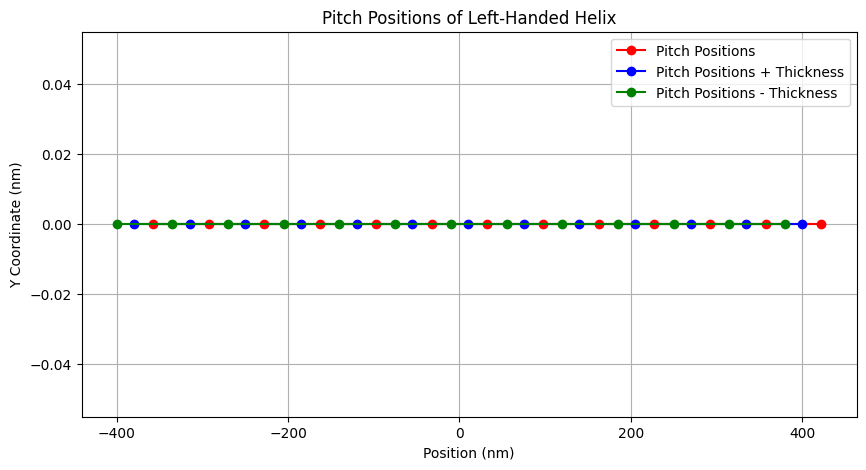

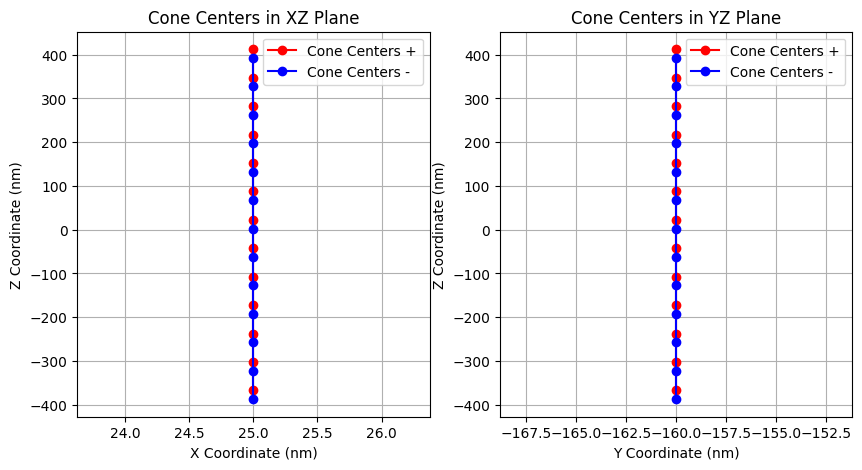

In [57]:
#---INFO---
print(f"Initial point of the left-handed helix: {point_0}")
print(f"Pitch of the left-handed helix: {pitch_left:.2f} nm")
dz = height_granum/2

pitch_positions = np.linspace((-total_height_helix/2)+(pitch_left/2), (total_height_helix/2)+(pitch_left/2), int(n_turns_left_helix + 1))
pitch_positions_plus_thickness = np.linspace((-total_height_helix/2) + dz, (total_height_helix/2) + dz, int(n_turns_left_helix + 1))
pitch_positions_minus_thickness = np.linspace((-total_height_helix/2) - dz, (total_height_helix/2) - dz, int(n_turns_left_helix + 1))
print(f"Pitch positions: {pitch_positions}")
print(f"Pitch positions (with thickness): {pitch_positions_plus_thickness}")
print(f"Pitch positions (without thickness): {pitch_positions_minus_thickness}")

# Plot the x and y coordinates of the pitch positions
plt.figure(figsize=(10, 5))
plt.plot(pitch_positions, np.zeros_like(pitch_positions), 'ro-', label='Pitch Positions')
plt.plot(pitch_positions_plus_thickness, np.zeros_like(pitch_positions_plus_thickness), 'bo-', label='Pitch Positions + Thickness')
plt.plot(pitch_positions_minus_thickness, np.zeros_like(pitch_positions_minus_thickness), 'go-', label='Pitch Positions - Thickness')
plt.legend()
plt.xlabel('Position (nm)')
plt.ylabel('Y Coordinate (nm)')
plt.title('Pitch Positions of Left-Handed Helix')
plt.grid()
plt.show()

cone_centers_plus = []
cone_centers_minus = []
for i in range(len(pitch_positions)):
    # Calculate the center of the cone for the plus and minus positions
    cone_center_plus = [inner_pore, -d_granum_helix+inner_pore*2, pitch_positions_plus_thickness[i] + (pitch_left/2) - (height_granum) ]
    cone_center_minus = [inner_pore, -d_granum_helix+inner_pore*2, pitch_positions_minus_thickness[i] + (pitch_left/2) - (height_granum) ]

    cone_centers_plus.append(cone_center_plus)
    cone_centers_minus.append(cone_center_minus)

# pLOT THE CENTERS IN THE xz plane and yz
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([c[0] for c in cone_centers_plus], [c[2] for c in cone_centers_plus], 'ro-', label='Cone Centers +')
plt.plot([c[0] for c in cone_centers_minus], [c[2] for c in cone_centers_minus], 'bo-', label='Cone Centers -')
plt.xlabel('X Coordinate (nm)')
plt.ylabel('Z Coordinate (nm)')
plt.title('Cone Centers in XZ Plane')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([c[1] for c in cone_centers_plus], [c[2] for c in cone_centers_plus], 'ro-', label='Cone Centers +')
plt.plot([c[1] for c in cone_centers_minus], [c[2] for c in cone_centers_minus], 'bo-', label='Cone Centers -')
plt.xlabel('Y Coordinate (nm)')
plt.ylabel('Z Coordinate (nm)')
plt.title('Cone Centers in YZ Plane')
plt.grid()
plt.legend()
plt.show()

In [ ]:
array_cone_centers_plus = np.array(cone_centers_plus)
array_cone_centers_minus = np.array(cone_centers_minus)
# Create cones at the calculated centers
cones_plus = []
cones_minus = []
for center_plus, center_minus in zip(array_cone_centers_plus, array_cone_centers_minus):
    cone_plus = mesh2.copy()
    cone_plus.points += np.array(center_plus) - cone_plus.center  # Translate to the new center
    cones_plus.append(cone_plus)

    cone_minus = mesh2.copy()
    cone_minus.points += np.array(center_minus) - cone_minus.center  # Translate to the new center
    cones_minus.append(cone_minus)

# Combine all cones into a single mesh
combined_cones = cones_plus[0]
for cone in cones_plus[1:]:
    combined_cones += cone
for cone in cones_minus[1:]:
    combined_cones += cone



In [ ]:
# Plot the cone centers
cone_plot = pv.Plotter(window_size=[1800, 600])
cone_plot.background_color = 'white'
# Add the combined cones
cone_plot.add_mesh(combined_cones, color='orange', show_edges=False)
# Add the reference left-handed helix mesh for comparison
cone_plot.add_mesh(left_helix_4[0], show_edges=False, color='R')
# Show axes and origin
cone_plot.show_axes()
# Show the plot
cone_plot.show()

# Planes

In [ ]:
plane_size = 500  # Size of the plane in nm

pitch_positions_z = np.linspace((-total_height_helix/2), (total_height_helix/2), int(n_turns_left_helix + 1)) # e.g. [-100, -50, 0, 50, 100]

x_ypisitions = ([])

#Generate a box in the pitch positions with the same width as the helix
pitch_boxes = []
for z in pitch_positions:
    box = pv.Cube(center=(0, 0, z), x_length=500, y_length=500, z_length=20)
    # Rotate 45 degrees around the z-axis
    box.rotate_z(45, inplace=True)

    pitch_boxes.append(box)
# Combine the pitch boxes into a single mesh
combined_pitch_boxes = pitch_boxes[0].copy()
for box in pitch_boxes[1:]:
    combined_pitch_boxes += box

# Model

In [ ]:
#--- Get reference information
point_0 = [0,d_granum_helix+inner_pore,-total_height_stacks/2]
point_1 = [0,-d_granum_helix+inner_pore,0]
point_2 = [d_granum_helix-inner_pore,0,0]
point_3 = [-d_granum_helix+inner_pore,0,0]
point_4 = [0,d_granum_helix-inner_pore,0]  # Added fourth point
centers = np.array([point_1, point_2, point_3, point_4])
theta = np.array([0,0, 0,45])  # Angles for the four points in degrees
translate = np.array([pitch_left/4, pitch_left/2,0,-pitch_left*.3])  # Translation vector for the four points
#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)
helix_points = generate_helix_spline(x0=point_1[0], y0=point_1[1], z0=point_1[2], radius=rxy_spline_left_helix+5*rxy_inner_left, pitch=pitch_left, turns=int(n_turns_left_helix), 
                         n_points=101, chirality='left')

helix_poitns = 



# Create elliptical tube around the path
#tube_mesh = create_elliptical_tube(
#    helix_points, 
#    major_radius=rz_inner_left, 
#    minor_radius=rxy_inner_left,
#    n_points=20 # Number of points in the cross-section
#)

tube_mesh = create_rectangular_tube(
    helix_points, 
    width=7 * rxy_inner_left, 
    height=2 * rz_inner_left, 
    n_points=101, 
    width_resolution=20,  # Number of points per side of the rectangular cross-section
    closed=False
)




## Center the tube mesh at the origin
#tube_mesh.points -= tube_mesh.center
#
left_helix_4 = []  # Initialize with the first tube mesh
n_right_helices = 4  # Number of right-handed helices
for j in range(n_right_helices): # Loop over the number of cylinders in the z direction
    # Translate the tube mesh to the center of the granum
    translated_tube = tube_mesh.copy()
    # Rotate the tube mesh around the z-axis
    #Center at the origin
    translated_tube.points -= translated_tube.center
    translated_tube.rotate_z(theta[j], inplace=True)  # Rotate by the specified angle
    translated_tube.points += centers[j] - translated_tube.center  # Translate to the new center
    # Translate in the z direction
    translated_tube.points[:, 2] += translate[j]
    left_helix_4.append(translated_tube)

combined_left_handed_helices = left_helix_4[0].copy()
for helix in left_helix_4[1:]:
    combined_left_handed_helices += helix

#pitch_positions = np.linspace(point_0[2]+(pitch_left/2), pitch_left*6.5, int(n_turns_left_helix + 1))




#Generate a box in the pitch positions with the same width as the helix
pitch_boxes = []
for z in pitch_positions:
    box = pv.Cube(center=(0, 0, z), x_length=500, y_length=500, z_length=20)
    # Rotate 45 degrees around the z-axis
    box.rotate_z(45, inplace=True)

    pitch_boxes.append(box)
# Combine the pitch boxes into a single mesh
combined_pitch_boxes = pitch_boxes[0].copy()
for box in pitch_boxes[1:]:
    combined_pitch_boxes += box

#--- Plot the left-handed helix 
left_helix_plot = pv.Plotter(window_size=[1800, 1600])
left_helix_plot.background_color = 'black'

# Change orthographic projection to view the helix from the side
left_helix_plot.camera.parallel_projection = True

#left_helix_plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)

left_helix_plot.add_mesh(combined_right_handed_helices, color='light_blue', show_edges=False)
left_helix_plot.add_mesh(left_helix_4[0], color='purple', show_edges=False)
#left_helix_plot.add_mesh(left_helix_4[1], color='light_blue', show_edges=False)
#left_helix_plot.add_mesh(left_helix_4[2], color='light_blue', show_edges=False)
#left_helix_plot.add_mesh(left_helix_4[3], color='light_blue', show_edges=False)
#
#left_helix_plot.add_mesh(combined_cones, color='orange', show_edges=False)
#right_helix_plot.add_mesh(reference_right_helix, color='blue', show_edges=False)
#left_helix_plot.add_mesh(combined_grana_cylinders, color='yellow', show_edges=False)
#left_helix_plot.add_mesh(combined_right_handed_helices_big, color='green', show_edges=False)
#Plot the pitch boxes
#left_helix_plot.add_mesh(combined_pitch_boxes, color='green', show_edges=False, opacity=0.5)

left_helix_plot.show()


Widget(value='<iframe src="http://localhost:40981/index.html?ui=P_0x7be353ac1b70_24&reconnect=auto" class="pyv…

## Second periodic model: Grana and helices

In [ ]:
#Filter the points that are within zi and zf
# Get cell centers directly using PyVista's method
cell_centers = combined_grana_cylinders.cell_centers().points

# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi 
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_grana = combined_grana_cylinders.extract_cells(cell_ind)

# Subgrid right-handed helicesS
cell_centers = combined_right_handed_helices.cell_centers().points
# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_right_helices = combined_right_handed_helices.extract_cells(cell_ind)

# Subgrid left-handed helices
cell_centers = combined_left_handed_helices.cell_centers().points
# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_left_helices = combined_left_handed_helices.extract_cells(cell_ind)

# Plot 3 copies
periodic_grana_plot = pv.Plotter(window_size=[1800, 600])
periodic_grana_plot.background_color = 'white'
periodic_grana_plot.add_mesh(subgrid_grana, color='yellow', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.add_mesh(subgrid_right_helices, color='blue', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.add_mesh(subgrid_left_helices, color='purple', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.show()


## Flat stroma lamellae

In [ ]:
# Single plane center at zero
#single_plane = pv.Plane(center=(0, 0, 0), direction=(0, 0, 1), i_size=400, j_size=400).triangulate()

#Rotate 45 degrees around the z-axis
#single_plane.rotate_z(45, inplace=True)
#second_plane = single_plane.copy()
# Translate the second plane to the z position of the stacks
#dz = -height_granum 
#second_plane.points += np.array([0, 0, dz])
side = 250
side2 = 500

box = pv.Box(bounds=(-side2, side2, -side2, side2, -height_granum, height_granum), level=int(side2/10)).triangulate()
box = box.rotate_z(45, inplace=True)
box.points += np.array([0, 0, -10])  # Center the box at the origin
second_box = box.copy()
# Translate the second box to the z position of the stacks
dz = 50
second_box.points += np.array([0, 0, dz])
#Rotate 45 degrees around the z-axis
#box = box.rotate_z(45, inplace=True)

third_box = pv.Box(bounds=(-45, side,-45, side, -height_granum+8, height_granum+8), level=int(side/10))
# Rotate 30 degrees around the x-axis
third_box.rotate_x(10, inplace=True)

fourth_box = pv.Box(bounds=(-45, side,-45, side, -height_granum+8, height_granum+8), level=int(side/10))
#Rotate 45 degrees around the z-axis
fourth_box.rotate_z(45, inplace=True)
fourth_box.rotate_y(10, inplace=True)
new_center = [-side*.75, side*.75, height_granum+20]
# Rotate 30 degrees around the x-axis
#fourth_box.rotate_x(30, inplace=True)
# Move the box to the new center
fourth_box.points += np.array(new_center) - fourth_box.center



plot_plane = pv.Plotter(window_size=[1800, 600])
plot_plane.background_color = 'black'
#plot_plane.add_mesh(single_plane, color='green', show_edges=False)
#plot_plane.add_mesh(second_plane, color='green', show_edges=False)
plot_plane.add_mesh(box, color='grey', show_edges=False)
plot_plane.add_mesh(second_box, color='grey', show_edges=False, opacity=0.5)

#plot_plane.add_mesh(third_box, color='green', show_edges=True)
#plot_plane.add_mesh(fourth_box, color='yellow', show_edges=True)
#plot_plane.add_mesh(combined_grana_cylinders, color='yellow', show_edges=False)
plot_plane.add_mesh(combined_right_handed_helices, color='blue', show_edges=False)
plot_plane.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)

plot_plane.show()

## Connecting the helices with the planes

In [ ]:
#--- Get reference information
theta_0 = 0
point_0 = [0,radius_granum,0]
#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)
helix_points = generate_helix_spline(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius=rxy_spline_right_helix+55, pitch=height_per_turn_right_helix+3, turns=n_turns_right_helix, 
                         n_points=101, chirality='right')

# Create elliptical tube around the path
tube_mesh = create_rectangular_tube(
    helix_points, 
    width=rz_right_helix+50, 
    height=rxy_right_helix*2, 
    n_points=101 # Number of points in the cross-section
)

# Center the tube mesh at the origin
tube_mesh.points -= tube_mesh.center

right_helix_big = []
n_right_helices_big = 4  # Number of right-handed helices
for j in range(n_right_helices_big): # Loop over the number of cylinders in the z direction

    #Rotate the tube mesh around the z-axis
    rotated_tube = tube_mesh.copy()
    rotated_tube.rotate_z(theta_0, inplace=True)
    right_helix_big.append(rotated_tube)
    theta_0 += 120

combined_right_handed_helices_big = right_helix_big[0].copy()
for helix in right_helix_big[1:]:
    combined_right_handed_helices_big += helix

###---USER DEFINED VARIABLES---###
rz_left_helix = 10                                              # Inner helix radius in the z direction (nm) 
rxy_left_helix = 10                                             # Outer helix radius parallel to the xy plane (nm)
height_per_turn_left_helix = total_height_right_helix/4                               # Height pitch the left-handed helix (nm)
d_granum_helix = total_radius_right_helix +25                   # Distance between the center of the granum and the center of the helix (nm)
###---END OF USER DEFINED VARIABLES---###

###---AUTO GENERATED VARIABLES---###
total_height_stacks = n_granum * granum_separation + (2 * height_granum)    # Total height of the stacks (nm)
n_turns_left_helix = 7.5     # Total number of turns in the helix
rz_spline_left_helix = (height_granum * n_turns_left_helix) - (2 * rz_left_helix)           # Height of the spline in the z direction (nm)
rxy_spline_left_helix = rxy_left_helix +20                    # Radius of the spline in the x direction (nm)
total_radius_helix = rxy_spline_left_helix + rxy_left_helix                # Total radius of the helix (nm)
total_height_helix = rz_spline_left_helix + (2 * rz_left_helix) 
###---END OF AUTO GENERATED VARIABLES---###

#--- Get reference information
point_0 = [0,d_granum_helix,-total_height_stacks/2]
point_1 = [0,-d_granum_helix*1.5,0]
point_2 = [d_granum_helix*1.5,0,0]
point_3 = [-d_granum_helix*1.5,0,total_height_stacks/n_turns_left_helix]
point_4 = [0,d_granum_helix*1.5,total_height_stacks/n_turns_left_helix]  # Added fourth point
centers = np.array([point_1, point_2, point_3, point_4])
#theta = np.array([180, 180, 180, 180])  # Angles for the four points in degrees
theta = np.array([180, 180, 180, 180])  # Angles for the four points in degrees

#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)
#helix_points = generate_helix_spline(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius=100, pitch=total_height_stacks/n_turns_left_helix, turns=n_turns_left_helix, 
#                         n_points=101, chirality='left')

helix_points = create_elliptical_helix(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius_x=100, radius_y=50, pitch=total_height_stacks/n_turns_left_helix, turns=n_turns_left_helix, n_points=101, chirality='left')

# Create elliptical tube around the path
tube_mesh = create_rectangular_tube(
    helix_points, 
    width=120, 
    height=rxy_left_helix*2, 
    n_points=101 # Number of points in the cross-section
)

## Center the tube mesh at the origin
#tube_mesh.points -= tube_mesh.center
#
left_helix_4 = []  # Initialize with the first tube mesh
n_right_helices = 4  # Number of right-handed helices
for j in range(n_right_helices): # Loop over the number of cylinders in the z direction
    # Translate the tube mesh to the center of the granum
    translated_tube = tube_mesh.copy()
    # Rotate the tube mesh around the z-axis
    #Center at the origin
    translated_tube.points -= translated_tube.center
    translated_tube.rotate_z(theta[j], inplace=True)  # Rotate by the specified angle
    translated_tube.points += centers[j] - translated_tube.center  # Translate to the new center

    left_helix_4.append(translated_tube)
    

combined_left_handed_helices_big = left_helix_4[0].copy()
for helix in left_helix_4[1:]:
    combined_left_handed_helices_big += helix

# Translate the boxes to the new center
#box.points += np.array([0, 0, height_granum+dz]) - box.center

#--- Plot the right-handed helix 
right_helix_plot = pv.Plotter(window_size=[1800, 600])
right_helix_plot.background_color = 'black'
right_helix_plot.add_mesh(combined_right_handed_helices, color='blue', show_edges=False)
right_helix_plot.add_mesh(combined_right_handed_helices_big, color='lightblue', show_edges=True)
#right_helix_plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)
right_helix_plot.add_mesh(combined_left_handed_helices_big, color='violet', show_edges=True)
right_helix_plot.add_mesh(box, color='grey', show_edges=False, opacity=1)
#right_helix_plot.add_mesh(second_box, color='grey', show_edges=False, opacity=1)

right_helix_plot.show()

In [ ]:
def add_material_labels(mesh, material_id, color_name):
    """Add material ID and color labels to any mesh (transferable function)."""
    # Add material ID as cell data (standard VTK approach)
    mesh.cell_data['material_id'] = np.full(mesh.n_cells, material_id)
    
    # Add color information
    mesh.cell_data['color_name'] = [color_name] * mesh.n_cells
    
    # Add RGB color values for visualization
    if color_name == 'red':
        rgb = [1.0, 0.0, 0.0]
    elif color_name == 'blue':
        rgb = [0.0, 0.0, 1.0]
    elif color_name == 'green':
        rgb = [0.0, 1.0, 0.0]
    elif color_name == 'yellow':
        rgb = [1.0, 1.0, 0.0]
    elif color_name == 'purple':
        rgb = [0.5, 0.0, 0.5]
    else:
        rgb = [0.5, 0.5, 0.5]  # default gray
    
    # Add RGB as point data for smooth visualization
    mesh.point_data['rgb_color'] = np.tile(rgb, (mesh.n_points, 1))
    
    return mesh


## Merging the models

### Right-handed helices + left-handed helices

In [ ]:
# Add material labels
for i, helix in enumerate(right_helix_4):
    add_material_labels(helix, material_id=1, color_name='blue')

for i, helix in enumerate(left_helix_4):
    add_material_labels(helix, material_id=2, color_name='purple')

#combined_right_handed_helices = combined_right_handed_helices.clean().fill_holes(1000)  # Clean the mesh to remove duplicate points
#combined_left_handed_helices = combined_left_handed_helices.clean().fill_holes(1000)  # Clean the

# Add material to combined left-handed helices
combined_right_handed_helices = add_material_labels(combined_right_handed_helices, material_id=1, color_name='blue')
combined_left_handed_helices = add_material_labels(combined_left_handed_helices, material_id=2, color_name='purple')

combined_helices = combined_left_handed_helices.boolean_union(right_helix_4[0])  # Start with the first helices
combined_helices = combined_helices.boolean_union(right_helix_4[1])  # Union with the second right-handed helix
combined_helices = combined_helices.boolean_union(right_helix_4[2])  # Union with the third right-handed helix




In [ ]:
plot_combined_helices = pv.Plotter(window_size=[1800, 600])
plot_combined_helices.background_color = 'white'
plot_combined_helices.add_mesh(combined_helices, scalars='material_id', 
                        cmap=['blue', 'purple'], show_edges=False)
plot_combined_helices.show()

In [ ]:
#Plot only a specific material
# Extract only the blue material (material_id == 1)
blue_material_cells = combined_helices.cell_data['material_id'] == 2
blue_mesh = combined_helices.extract_cells(blue_material_cells)

plot_combined_helices_blue = pv.Plotter(window_size=[1800, 600])
plot_combined_helices_blue.background_color = 'white'
plot_combined_helices_blue.add_mesh(blue_mesh, color='purple', show_edges=True,
                        show_scalar_bar=False,
                        opacity=0.5)
plot_combined_helices_blue.show()

### Left-handed helices v2

In [ ]:
#---Load the meshes with materials---
obj_path = f"{wdir}/Reference_objs/reference_left_handed_helices.obj"
mtl_path = f"{wdir}/Reference_objs/reference_left_handed_helices.mtl"        
reference_left_helix2 = load_obj_with_materials(obj_path, mtl_path)

# Merge the meshes if there are multiple meshes
reference_left_helix = reference_left_helix2[0] 
if len(reference_left_helix2) > 1:
    for mesh in reference_left_helix2[1:]:
        reference_left_helix += mesh

# Move the center of the mesh to the origin
reference_left_helix.points -= reference_left_helix.center

#---Pre-processing---
# Scale by 4000 to convert to nm
reference_left_helix.points *= 4000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
reference_left_helix.rotate_x(90, inplace=True)

# Center the mesh at the origin
reference_left_helix.points -= reference_left_helix.center

#---Plot---
# Create a Plotter object
plot_reference_left_helix = pv.Plotter(window_size=[1600, 600])
plot_reference_left_helix.background_color = 'black'

# Add reference_left_helix
colors = reference_left_helix['material_color']
plot_reference_left_helix.add_mesh(reference_left_helix, scalars=colors, rgb=True, show_edges=False)

# Show axes and origin
plot_reference_left_helix.show_axes()
# Add the origin point
plot_reference_left_helix.add_mesh(pv.Sphere(radius=10, center=(0, 0, 0)), color='red')
# Add point in the maximum z position
max_z_point = reference_left_helix.points[reference_left_helix.points[:, 2].argmax()]
plot_reference_left_helix.add_mesh(pv.Sphere(radius=10, center=(0, 0, max_z_point[2])), color='green')
# Add point in the minimum z position
min_z_point = reference_left_helix.points[reference_left_helix.points[:, 2].argmin()]
plot_reference_left_helix.add_mesh(pv.Sphere(radius=10, center=(0, 0, min_z_point[2])), color='blue')

# Merge spheres and obj files
# Create a sphere at the origin
origin_sphere = pv.Sphere(radius=10, center=(0, 0, 0))
# Create a sphere at the maximum z position
max_z_sphere = pv.Sphere(radius=10, center=(0, 0, max_z_point[2]))
# Create a sphere at the minimum z position
min_z_sphere = pv.Sphere(radius=10, center=(0, 0, min_z_point[2]))

# Combine the spheres and the reference_left_helix mesh
combined_mesh = origin_sphere + max_z_sphere + min_z_sphere + reference_left_helix

# Save the combined mesh to an OBJ file
combined_mesh.save(f"{wdir}/Reference_objs/combined_reference_left_handed_helix.obj")

# Show the plot
plot_reference_left_helix.show()

In [ ]:
combined_helices2 = combined_helices.boolean_union(second_plane)  # Union with the second plane

# Placing PSII randomly selecting points

In [ ]:
#Sum area
print("Total area remeshed mesh: ", np.sum(area_1), "nm^2")
#Convert to um^2
total_area = np.sum(area_1) / 1e6
print("Total area remeshed mesh: ", total_area, "um^2")

In [ ]:
#Concentration particles per um^2 Based on Engel 2024
concentration_psii=1415
concentration_cytb=446
n_psii=int(total_area*concentration_psii)
print("Number of PSII per granum: ", n_psii)
n_cytb=int(total_area*concentration_cytb)
print("Number of Cytb6f per granum: ", n_cytb)

In [ ]:
#ellipsoids_mesh[0]
# Select n random points from the ellipsoid
random_points, random_indices = select_random_points(remesh, 
                                                    n_points=n_psii, 
                                                    seed=42)  # Set seed for reproducibility

# Plot the ellipsoid with highlighted random points
plot_mesh_with_highlighted_points(remesh, 
                                  random_points,
                                  mesh_color='lightblue',
                                  point_color='yellow',
                                  point_size=11)

# If you want to print the indices of the selected points
n_random_points = len(random_indices)
print(f"Selected point indices: {n_random_points}")

# Placing PSII matching NN distribution

###  Taken from Engel et. al. 2024 (Figure 6) 

### (A) Two main complexes in the grana region

![Screenshot from 2025-05-22 09-42-04.png](<attachment:Screenshot from 2025-05-22 09-42-04.png>)
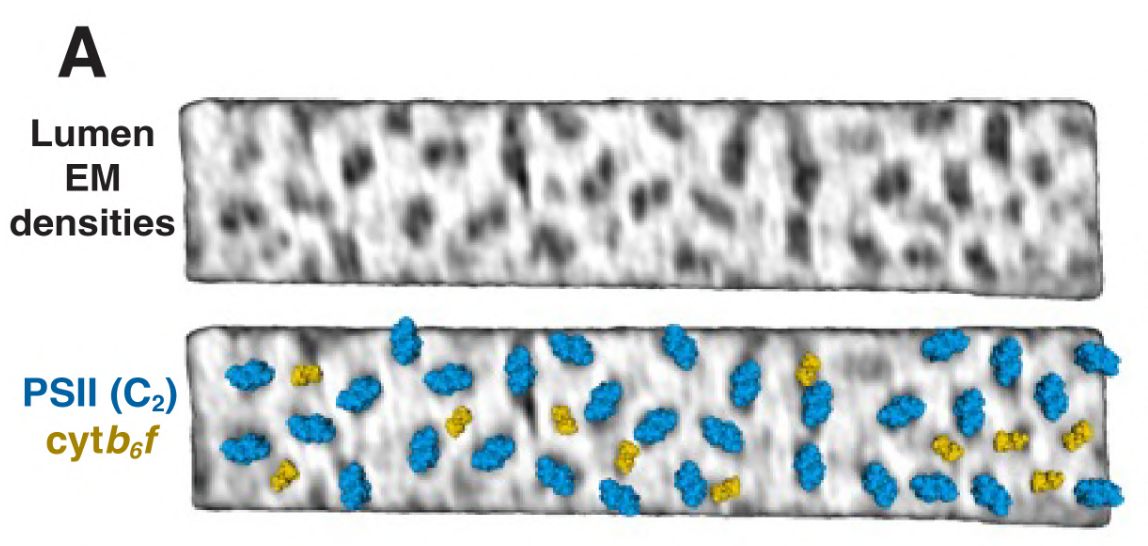

### (B) Nearest-Neighbor distances

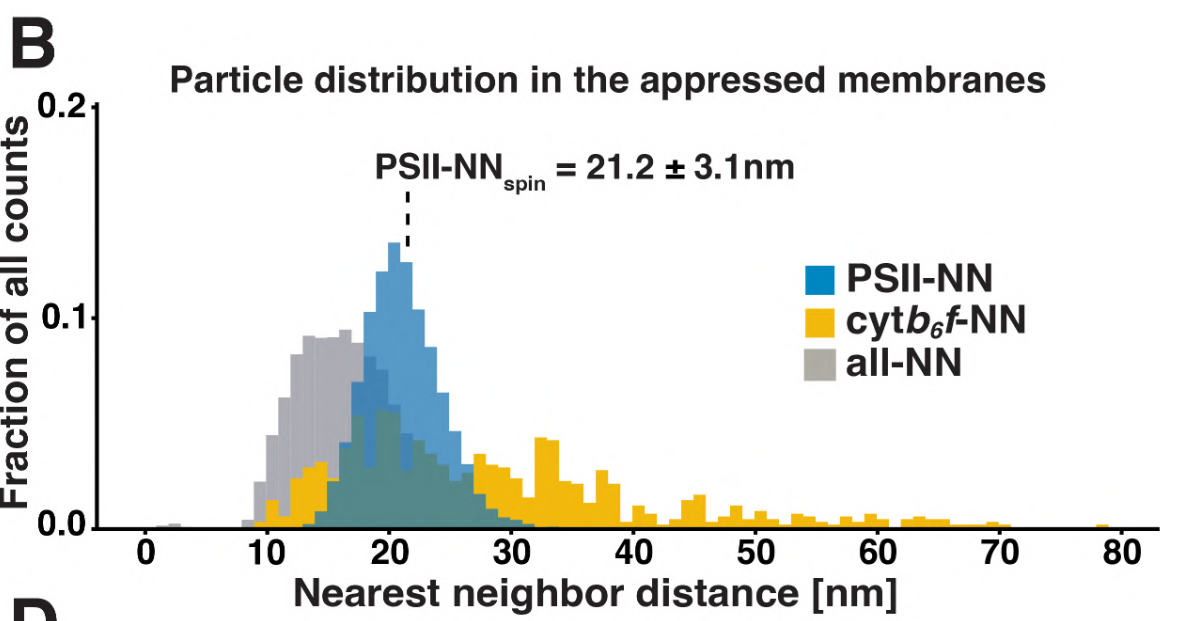

In [ ]:
# Generate reference Gaussian distribution of points
gaussian_points = generate_nn_distances(n_psii, mean=21.2, std=3.1, seed=42)
# Plot the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(gaussian_points, bins=10, color='blue', alpha=0.7)
plt.xlabel('Distance (nm)')
plt.ylabel('Frequency')
plt.title('Gaussian Distribution of Distances')
plt.grid()
plt.show()

In [ ]:
#From the paper, we want an average distance of 21.2 nm and a std deviation of 3.1 nm, but here we might need to adjust the target for the iteration

# Generate points on your mesh following a Gaussian NN-distance distribution
#distributed_points = distribute_points_gaussian(
#    mesh=remesh,
#    n_points=n_psii,  # Number of points you want
#    mean_distance=23,  # Your target mean distance
#    std_distance=1,    # Your target std deviation
#    seed=42             # For reproducibility
#)
distributed_points, forbidden_points = distribute_points_gaussian(
    mesh=remesh,
    n_points=n_psii,     # Number of points you want
    mean_distance=25,  # Your target mean distance
    std_distance=0.2,    # Your target std deviation
    max_attempts=10000, # Number of attempts to place each point
    forbiden_radius=10, # Radius of the forbidden cylinder (PSII size + 1.2 nm)
    forbiden_height=6,  # Height of the forbidden cylinder
    seed=42             # For reproducibility
)

# Visualize points on the mesh
plot_mesh_with_highlighted_spheres(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=11 #PSII size
)

# Analyze how well the distribution matches the target Gaussian
analysis = analyze_point_distribution(
    points=distributed_points,
    target_mean=21.2,
    target_std=3.1
)

print(f"Target distribution: mean={analysis['target_mean']:.2f}, std={analysis['target_std']:.2f}")
print(f"Actual distribution: mean={analysis['actual_mean']:.2f}, std={analysis['actual_std']:.2f}")
print(f"KS test: statistic={analysis['ks_statistic']:.4f}, p-value={analysis['ks_pvalue']:.4f}")

n_points = len(distributed_points)
print(f"Number of points distributed: {n_points}")

In [ ]:
print(distributed_points.dtype)
print(forbidden_points.dtype)

In [ ]:
# Visualize points on the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=forbidden_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=10 #PSII size
)


In [ ]:
def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, width_resolution=4, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points along the spline to sample for cross-sections.
        
    width_resolution : int, default: 4
        Number of points per side of the rectangular cross-section.
        Higher values create smoother, more detailed cross-sections.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    from scipy.interpolate import interp1d
    
    # Resample spline to n_points if necessary
    if len(spline_points) != n_points:
        # Create parameter array for original points
        t_original = np.linspace(0, 1, len(spline_points))
        
        # Create interpolation functions for each coordinate
        interp_x = interp1d(t_original, spline_points[:, 0], kind='cubic')
        interp_y = interp1d(t_original, spline_points[:, 1], kind='cubic')
        interp_z = interp1d(t_original, spline_points[:, 2], kind='cubic')
        
        # Generate new parameter array with n_points
        t_new = np.linspace(0, 1, n_points)
        
        # Interpolate to get new points
        resampled_points = np.column_stack([
            interp_x(t_new),
            interp_y(t_new),
            interp_z(t_new)
        ])
    else:
        resampled_points = spline_points
    
    # Calculate tangents and normals
    tangents = np.gradient(resampled_points, axis=0)
    
    # Normalize tangents
    tangent_lengths = np.linalg.norm(tangents, axis=1)
    tangent_lengths[tangent_lengths == 0] = 1  # Avoid division by zero
    tangents = tangents / tangent_lengths[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section with specified resolution
    half_width = width / 2.0
    half_height = height / 2.0
    
    # Create rectangle points with width_resolution points per side
    rectangle = []
    
    # Bottom side: left to right
    for i in range(width_resolution):
        x = -half_width + (i / (width_resolution - 1)) * width
        rectangle.append([x, -half_height, 0])
    
    # Right side: bottom to top (excluding corners already added)
    for i in range(1, width_resolution):
        y = -half_height + (i / (width_resolution - 1)) * height
        rectangle.append([half_width, y, 0])
    
    # Top side: right to left (excluding corners already added)
    for i in range(1, width_resolution):
        x = half_width - (i / (width_resolution - 1)) * width
        rectangle.append([x, half_height, 0])
    
    # Left side: top to bottom (excluding corners already added)
    for i in range(1, width_resolution - 1):
        y = half_height - (i / (width_resolution - 1)) * height
        rectangle.append([-half_width, y, 0])
    
    rectangle = np.array(rectangle)
    points_per_section = len(rectangle)
    
    # Generate tube mesh
    for i, point in enumerate(resampled_points):
        t = tangents[i]
        
        # Create a simple rotation matrix (can be improved for better orientation)
        # For now, keep rectangle in XY plane and translate
        rotation = np.eye(3)
        
        # Transform rectangle points to this position
        for corner in rectangle:
            # Rotate and translate rectangle point
            tube_points.append(point + np.dot(rotation, corner))
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(points_per_section):
                idx1 = (i-1) * points_per_section + j
                idx2 = (i-1) * points_per_section + (j+1) % points_per_section
                idx3 = i * points_per_section + (j+1) % points_per_section
                idx4 = i * points_per_section + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested   
    if closed and len(resampled_points) > 2:
        # Connect last cross-section to first
        for j in range(points_per_section):
            idx1 = (len(resampled_points)-1) * points_per_section + j
            idx2 = (len(resampled_points)-1) * points_per_section + (j+1) % points_per_section
            idx3 = (j+1) % points_per_section
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

In [ ]:
#Drop points in the mesh were we placed the PSII and 22nm around
def drop_points_in_sphere(mesh, points, radius=22):
    """
    Drop points in a sphere around the specified points on the mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to drop points.
        
    points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the center points.
        
    radius : float, default: 22
        Radius of the sphere around each point where points will be dropped.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_dropped_points, 3) containing the coordinates of the dropped points.
    """
    import numpy as np
    
    # Initialize list to store dropped points
    dropped_points = []
    
    # Iterate over each point
    for point in points:
        # Calculate distances from this point to all other points in the mesh
        distances = np.linalg.norm(mesh.points - point, axis=1)
        
        # Find indices of points within the specified radius
        indices_to_drop = np.where(distances <= radius)[0]
        
        # Append these points to the list of dropped points
        dropped_points.extend(mesh.points[indices_to_drop])
    
    return np.array(dropped_points)

def drop_points_in_cylinder(mesh, points, radius=22, height=10):
    """
    Drop points in a cylinder around the specified points on the mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to drop points.
        
    points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the center points.
        
    radius : float, default: 22
        Radius of the cylinder around each point where points will be dropped.
        
    height : float, default: 10
        Height of the cylinder.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_dropped_points, 3) containing the coordinates of the dropped points.
    """
    import numpy as np
    
    # Initialize list to store dropped points
    dropped_points = []
    
    # Iterate over each point
    for point in points:
        # Calculate distances from this point to all other points in the mesh
        distances = np.linalg.norm(mesh.points - point, axis=1)
        
        # Find indices of points within the specified radius and height
        indices_to_drop = np.where((distances <= radius) & 
                                    (np.abs(mesh.points[:, 2] - point[2]) <= height))[0]
        
        # Append these points to the list of dropped points
        dropped_points.extend(mesh.points[indices_to_drop])
    
    return np.array(dropped_points)




In [ ]:
dropped_points = drop_points_in_cylinder(
    mesh=remesh,
    points=distributed_points,
    radius=11,  # Radius of the cylinder
    height=3   # Height of the cylinder
)
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=dropped_points,
    mesh_color='lightyellow',
    point_color='red',
    point_size=5
)

# Adding the cytochrome b6f

In [ ]:
#Remove points from the mesh
#remesh_without_psii = remove_points_from_mesh(remesh, dropped_points)

In [ ]:
#Try with the new mesh
distributed_points = distribute_points_gaussian(
    mesh=remesh_without_psii,
    n_points=n_cytb,  # Number of points you want
    mean_distance=40,  # Your target mean distance
    std_distance=5,    # Your target std deviation
    seed=42,             # For reproducibility
    clear_radius=1
)
# Visualize points on the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=5
)

#Plot psii points to the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='blue',
    point_size=5
)


# NOTES

For the grana:

The average cell size in the remeshed mesh is 0.11 nm^2.
The standard deviation of the cell sizes in the remeshed mesh is 0.01 nm^2.

For the right helix:
The tube mesh has 4000 faces.
The total avg and std area of the tube mesh are 0.04 nm^2 and 0.01 nm^2, respectively.

In [ ]:
# Test the rectangular tube function
def test_rectangular_tube():
    """Simple test to visualize the rectangular tube function."""
    
    # Create a simple curved path (helix-like)
    t = np.linspace(0, 4*np.pi, 50)
    radius = 2.0
    spline_points = np.column_stack([
        radius * np.cos(t),
        radius * np.sin(t),
        t * 0.5  # Rising helix
    ])
    
    print("Testing rectangular tube creation...")
    print(f"Input spline: {len(spline_points)} points")
    
    # Test different n_points values
    test_cases = [
        {'n_points': 10, 'width': 0.5, 'height': 0.3, 'closed': False},
        {'n_points': 20, 'width': 0.8, 'height': 0.4, 'closed': False},
        {'n_points': 50, 'width': 5, 'height': 0.6, 'closed': False}
    ]
    
    # Create plotter for visualization
    plotter = pv.Plotter(shape=(1, 3), window_size=[1200, 400])
    
    for i, params in enumerate(test_cases):
        print(f"\nTest case {i+1}: n_points={params['n_points']}, "
              f"width={params['width']}, height={params['height']}")
        
        # Create tube
        tube = create_rectangular_tube(spline_points, **params)
        
        print(f"  Result: {tube.n_points} points, {tube.n_cells} cells")
        
        # Add to visualization
        plotter.subplot(0, i)
        plotter.add_mesh(tube, color='lightblue', opacity=1, show_edges=True)
        
        # Add the original spline path for reference
        spline_poly = pv.PolyData(spline_points)
        plotter.add_mesh(spline_poly, color='red', point_size=5, render_points_as_spheres=True)
        
        plotter.add_title(f"n_points={params['n_points']}")
    
    # Show visualization
    plotter.show()
    
    return test_cases

# Run the test
test_results = test_rectangular_tube()

In [ ]:
def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, width_resolution=4, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points along the spline to sample for cross-sections.
        
    width_resolution : int, default: 4
        Number of points per side of the rectangular cross-section.
        Higher values create smoother, more detailed cross-sections.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    from scipy.interpolate import interp1d
    
    # Resample spline to n_points if necessary
    if len(spline_points) != n_points:
        # Create parameter array for original points
        t_original = np.linspace(0, 1, len(spline_points))
        
        # Create interpolation functions for each coordinate
        interp_x = interp1d(t_original, spline_points[:, 0], kind='cubic')
        interp_y = interp1d(t_original, spline_points[:, 1], kind='cubic')
        interp_z = interp1d(t_original, spline_points[:, 2], kind='cubic')
        
        # Generate new parameter array with n_points
        t_new = np.linspace(0, 1, n_points)
        
        # Interpolate to get new points
        resampled_points = np.column_stack([
            interp_x(t_new),
            interp_y(t_new),
            interp_z(t_new)
        ])
    else:
        resampled_points = spline_points
    
    # Calculate tangents and normals
    tangents = np.gradient(resampled_points, axis=0)
    
    # Normalize tangents
    tangent_lengths = np.linalg.norm(tangents, axis=1)
    tangent_lengths[tangent_lengths == 0] = 1  # Avoid division by zero
    tangents = tangents / tangent_lengths[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section with specified resolution
    half_width = width / 2.0
    half_height = height / 2.0
    
    # Create rectangle points with width_resolution points per side in local 2D coordinates
    rectangle_2d = []
    
    # Bottom side: left to right
    for i in range(width_resolution):
        x = -half_width + (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, -half_height])
    
    # Right side: bottom to top (excluding corners already added)
    for i in range(1, width_resolution):
        y = -half_height + (i / (width_resolution - 1)) * height
        rectangle_2d.append([half_width, y])
    
    # Top side: right to left (excluding corners already added)
    for i in range(1, width_resolution):
        x = half_width - (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, half_height])
    
    # Left side: top to bottom (excluding corners already added)
    for i in range(1, width_resolution - 1):
        y = half_height - (i / (width_resolution - 1)) * height
        rectangle_2d.append([-half_width, y])
    
    rectangle_2d = np.array(rectangle_2d)
    points_per_section = len(rectangle_2d)
    
    # Generate tube mesh
    for i, center_point in enumerate(resampled_points):
        tangent = tangents[i]
        
        # Create local coordinate system at this point
        # Tangent is the Z-axis of local system
        local_z = tangent
        
        # Create a reasonable local X and Y axis
        # Choose an arbitrary vector not parallel to tangent
        if abs(local_z[2]) < 0.9:
            temp_vector = np.array([0, 0, 1])
        else:
            temp_vector = np.array([1, 0, 0])
        
        # Create local X axis (perpendicular to tangent)
        local_x = np.cross(local_z, temp_vector)
        local_x = local_x / np.linalg.norm(local_x)
        
        # Create local Y axis (perpendicular to both)
        local_y = np.cross(local_z, local_x)
        local_y = local_y / np.linalg.norm(local_y)
        
        # Create rotation matrix from local to global coordinates
        rotation_matrix = np.column_stack([local_x, local_y, local_z])
        
        # Transform rectangle points to 3D and orient them
        for local_point_2d in rectangle_2d:
            # Convert 2D rectangle point to 3D local coordinates
            local_point_3d = np.array([local_point_2d[0], local_point_2d[1], 0])
            
            # Rotate to global orientation and translate to center point
            global_point = center_point + np.dot(rotation_matrix, local_point_3d)
            tube_points.append(global_point)
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(points_per_section):
                idx1 = (i-1) * points_per_section + j
                idx2 = (i-1) * points_per_section + (j+1) % points_per_section
                idx3 = i * points_per_section + (j+1) % points_per_section
                idx4 = i * points_per_section + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested   
    if closed and len(resampled_points) > 2:
        # Connect last cross-section to first
        for j in range(points_per_section):
            idx1 = (len(resampled_points)-1) * points_per_section + j
            idx2 = (len(resampled_points)-1) * points_per_section + (j+1) % points_per_section
            idx3 = (j+1) % points_per_section
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

In [ ]:
# Test width resolution parameter
def test_width_resolution():
    """Test the width_resolution parameter to see cross-section detail."""
    
    # Create a simple straight path for clearer visualization
    t = np.linspace(0, 10, 20)
    spline_points = np.column_stack([
        t,
        np.zeros(len(t)),
        np.zeros(len(t))
    ])
    
    print("Testing width resolution parameter...")
    
    # Test different width_resolution values
    test_cases = [
        {'width_resolution': 4, 'width': 2.0, 'height': 1.0},   # Basic rectangle (4 corners)
        {'width_resolution': 8, 'width': 2.0, 'height': 1.0},   # More detailed
        {'width_resolution': 16, 'width': 2.0, 'height': 1.0}   # High detail
    ]
    
    # Create plotter for visualization
    plotter = pv.Plotter(shape=(2, 3), window_size=[1200, 800])
    
    for i, params in enumerate(test_cases):
        print(f"\nTest case {i+1}: width_resolution={params['width_resolution']}")
        
        # Create tube
        tube = create_rectangular_tube(spline_points, n_points=10, **params)
        
        print(f"  Result: {tube.n_points} points, {tube.n_cells} cells")
        print(f"  Points per cross-section: {tube.n_points // 10}")
        
        # Side view (along tube)
        plotter.subplot(0, i)
        plotter.add_mesh(tube, color='lightgreen', opacity=0.8, show_edges=True)
        plotter.add_mesh(pv.PolyData(spline_points), color='red', point_size=8, 
                        render_points_as_spheres=True)
        plotter.add_title(f"Side View - Res: {params['width_resolution']}")
        plotter.camera_position = 'yz'
        
        # End view (cross-section)
        plotter.subplot(1, i)
        plotter.add_mesh(tube, color='lightblue', opacity=0.8, show_edges=True)
        plotter.add_title(f"End View - Res: {params['width_resolution']}")
        plotter.camera_position = 'xy'
        
        # Set view to see cross-section clearly
        plotter.camera.position = (15, 0, 0)
        plotter.camera.focal_point = (0, 0, 0)
        plotter.camera.up = (0, 0, 1)
    
    plotter.show()
    
    return test_cases

# Run width resolution test
width_test_results = test_width_resolution()

In [ ]:
# Test proper rectangle centering and orientation
def test_rectangle_orientation():
    """Test that rectangles are properly centered and oriented perpendicular to spline."""
    
    print("Testing rectangle orientation and centering...")
    
    # Create test cases with different curve types
    test_cases = []
    
    # 1. Straight line (should be easy to verify)
    straight_points = np.array([
        [0, 0, 0],
        [2, 0, 0], 
        [4, 0, 0],
        [6, 0, 0]
    ])
    test_cases.append(("Straight Line", straight_points))
    
    # 2. 90-degree bend
    bend_points = np.array([
        [0, 0, 0],
        [2, 0, 0],
        [4, 0, 0], 
        [4, 2, 0],
        [4, 4, 0]
    ])
    test_cases.append(("90° Bend", bend_points))
    
    # 3. Helix (3D curve)
    t = np.linspace(0, 2*np.pi, 20)
    helix_points = np.column_stack([
        2 * np.cos(t),
        2 * np.sin(t),
        t * 0.5
    ])
    test_cases.append(("3D Helix", helix_points))
    
    # Create plotter
    plotter = pv.Plotter(shape=(1, 3), window_size=[1200, 400])
    
    for i, (name, spline_points) in enumerate(test_cases):
        print(f"\nTest case: {name}")
        
        # Create tube with clear parameters
        tube = create_rectangular_tube(
            spline_points, 
            width=1.0, 
            height=0.5, 
            n_points=10,
            width_resolution=4,
            closed=False
        )
        
        print(f"  Created tube: {tube.n_points} points, {tube.n_cells} cells")
        
        # Visualize
        plotter.subplot(0, i)
        
        # Add tube with transparency to see internal structure
        plotter.add_mesh(tube, color='lightblue', opacity=0.7, show_edges=True)
        
        # Add centerline spline for reference
        spline_poly = pv.PolyData(spline_points)
        plotter.add_mesh(spline_poly, color='red', line_width=8)
        
        # Add spline points as spheres
        plotter.add_mesh(spline_poly, color='darkred', point_size=12, 
                        render_points_as_spheres=True)
        
        plotter.add_title(name)
        
        # Set good viewing angle
        if i == 2:  # For helix, use 3D view
            plotter.view_isometric()
        else:
            plotter.view_xy()
    
    plotter.show()
    
    return test_cases

# Run orientation test
orientation_test = test_rectangle_orientation()

# Model drawing

In [ ]:
import math
def helix_radius_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the helix radius required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required helix radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))



In [ ]:
radius_granum = 250.0  # Example radius in nm
height_granum = 20.0  # Example height in nm
radius_right = radius_granum + (height_granum / 2) 
tilt_angle_right = 15.9  # Desired tilt angle in degrees

pitch_right = helix_pitch_from_tilt(radius, tilt_angle_right)
print(f"Calculated pitch for right-handed helix: {pitch_right:.2f} nm")

In [ ]:
# Right-handed spiral helix
starting_point = np.array([0, 0, 0])
pitch_right = pitch_right  # Pitch of the helix
n_turns = 1  # Number of turns based on height


spline_right = helix_points = create_elliptical_helix(x0=starting_point[0], y0=starting_point[1], z0=starting_point[2], radius_x=radius_right, radius_y=radius_right, pitch=total_height_stacks/n_turns, turns=n_turns, n_points=101, chirality='right')

tube_mesh = create_rectangular_tube(spline_right, width=height_granum, height=height_granum, n_points=101, width_resolution=4, closed=False)

# Create a Plotter object
plot_right_helix = pv.Plotter(window_size=[1600, 600])
plot_right_helix.background_color = 'black'
# Add the right-handed helix mesh
plot_right_helix.add_mesh(tube_mesh, color='lightblue', show_edges=True)
# Show axes and origin
plot_right_helix.show_axes()

# Show the plot
plot_right_helix.show()